# 0.0 General Area

## 0.1 Import Libraries

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

import math 
import inflection
import datetime
import pickle
import warnings
import random
import json
import requests


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy

from scipy                 import stats as ss

warnings.filterwarnings( 'ignore' )

## 0.2 Support Functions

In [2]:
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    return df

def fillout_na( df ):
    # competition_distance with NA values means "no competitor around". Set max value = 200000
    max_value = df['competition_distance'].max()
    df['competition_distance'] = df['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

    # competition_open_since_month and competition_open_since_year 
    # Set month and year of sale as default value
    df['competition_open_since_month'] = df.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    df['competition_open_since_year']  = df.apply( lambda x: x['date'].year if math.isnan(  x['competition_open_since_year'] )  else x['competition_open_since_year'], axis=1 )

    # promo2_since_week  and promo2_since_year
    # Set month and year of sale as default value
    df['promo2_since_week'] = df.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
    df['promo2_since_year'] = df.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    # promo_interval  - first, create a new column(month_map) with the month of sale  
    month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
    df['promo_interval'].fillna( 0, inplace=True )
    df['month_map'] = df['date'].dt.month.map( month_map )

    # promo_inteval - second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
    df['is_promo'] = df[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 

    return df

def change_data_types( df ):
    df['competition_open_since_month']  = df['competition_open_since_month'].astype( int )
    df['competition_open_since_year']   = df['competition_open_since_year'].astype( int )
    df['promo2_since_week']             = df['promo2_since_week'].astype( int )
    df['promo2_since_year']             = df['promo2_since_year'].astype( int )

    return df 


def data_cleaning( df ):

    df = rename_columns( df )
    df = fillout_na( df )
    df = change_data_types( df )

    return df


def create_features( df ):
    # year
    df['year'] = df['date'].dt.year

    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

    # year week
    df['year_week'] = df.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

    # from competition_open_since columns
    df['competition_since']      = df.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
    df['competition_time_month'] = df.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

    # from promo2_since
    df['promo2_since']     = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
    df['promo2_since']     = df['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df['promo2_time_week'] = df.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

    #  describes an assortment level: a = basic, b = extra, c = extended
    df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

    # Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
    # a = public holiday, b = easter holiday, c = christmas, 0 = regular day
    df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

    return df

def remove_rows( df ):
    # remove lines where there are no sales
    df = df[ ( df['open'] != 0 ) & ( df['sales'] > 0 ) ]

    return df

def drop_cols( df ):
    # customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição. 
    # open -> Se a loja está aberta ou não. Quando está fechada não há vendas, ou seja, devem ser consideradas apenas as linhas com loja aberta ( open != 0 )
    # sales -> Valor total em vendas. Quando não há vendas desconsiderar linhas ( sales > 0 )
    # colunas que foram criadas apenas para auxiliar a geração de outras também devem ser excluídas. Ex: promo_interval, month_map

    cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
    df = df.drop( cols_drop, axis=1 )

    return df

def feature_engineering( df ):
    df = create_features( df )
    df = remove_rows( df )
    df = drop_cols( df )

    return df

def rescaling_features( df, df_type ):
    # Apply MinMaxScaler - promo2_time_week
    mms = MinMaxScaler()
    df['promo2_time_week'] = mms.fit_transform( df[['promo2_time_week']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/promo2_time_week_scaler.pkl', 'wb' ) )

    # Apply MinMaxScaler - year
    mms = MinMaxScaler()
    df['year'] = mms.fit_transform( df[['year']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/year_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_distance
    rs = RobustScaler()
    df['competition_distance'] = rs.fit_transform( df[['competition_distance']].values )
    if df_type == 'train':    
        pickle.dump( rs, open( '../parameters/competition_distance_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_time_month
    rs = RobustScaler()
    df['competition_time_month'] = rs.fit_transform( df[['competition_time_month']].values )
    if df_type == 'train':
        pickle.dump( rs, open( '../parameters/competition_time_month_scaler.pkl', 'wb' ) )

    return df 

def encoding_features( df, df_type ):
    # Apply One-Hot Encoding - state_holiday
    df = pd.get_dummies( df, prefix=['state_holiday'], columns=['state_holiday'] )     

    # Apply Label Encoding - store_type
    le = LabelEncoder()
    df['store_type'] = le.fit_transform( df['store_type'])
    if df_type == 'train':
        pickle.dump( le, open( '../parameters/store_type_scaler.pkl', 'wb' ) )       

    # Apply Ordinal Encoding - assortment
    assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
    df['assortment'] = df['assortment'].map( assortment_dict )

    return df

def magnitude_features( df ):
    # Apply Logarithm Transformation - response variable (sales)
    df['sales'] = np.log1p( df['sales'] ) 

    return df

def ciclyc_features( df ):
    # Calculate sin and cos - month - variable with cyclic behavior
    df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
    df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

    # Calculate sin and cos - day_of_week - variable with cyclic behavior
    df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
    df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

    # Calculate sin and cos - day - variable with cyclic behavior
    df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
    df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

    # Calculate sin and cos - week_of_year - variable with cyclic behavior
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

    return df


def data_preparation( df, df_type ):

    # apply rescaling methods 
    df = rescaling_features( df, df_type )   

    # apply enconding methods to categorical features
    df = encoding_features( df, df_type )

    # change features magnitude
    df = magnitude_features( df )

    # apply method to features with cyclical behavior
    df = ciclyc_features( df )

    return df


# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

#def mean_absolute_percentage_error( y, yhat ):
#    return np.round( np.mean( np.abs( ( y - yhat ) / y ) ) * 100, 2 )

def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list =  []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date   = x_training['date'].max() - datetime.timedelta( days=( k-1 )*6*7 )

        if verbose:
            print(f'\nValidation Block: { k }. Dates: { validation_start_date } - { validation_end_date }' )

                                                                            
        # filtering dataset
        training   = x_training[ x_training['date'] <= validation_start_date]
        validation = x_training[ (x_training['date'] > validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE CV'  : np.round( np.mean( mae_list ),  2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )
                        }, index=[0] )

def get_model_prediction( test_file, server_name ):
    x_test = pd.read_csv( test_file,  low_memory= False )

    # remove close day
    x_test = x_test[ ( x_test['open'] != 0 ) ]

    y_test = x_test['sales'].values
    x_test = x_test.drop( columns=['sales'], axis=1 )

    # convert dataframe to json
    json_data = json.dumps( x_test.to_dict( orient='records' ) )

    # API CALL

    # Render´s Server request
    url = 'https://rossmann-app-9l04.onrender.com/rossmann/predict'

    # local request
    if server_name == 'local':
        url = 'http://0.0.0.0:5000/rossmann/predict'

    
    header = { 'Content-type' : 'application/json' }
    response = requests.post( url, data=json_data, headers=header )

    check_status = response.status_code

    if check_status == 200:
        # return dataframe with predictions
        df = pd.DataFrame( response.json(), columns=response.json()[0].keys() )
        df = df[['store', 'date', 'sales_predictions']]

        df['sales']          = y_test
        df['absolute_error'] = np.abs( y_test - df['sales_predictions'].values )

        return df
    
    else:
        return pd.DataFrame()


def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

## 0.3 Load Data

In [3]:
# reading data
df_train_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store.csv', low_memory= False )

# merging datasets train and store
df_train_raw = pd.merge( df_train_raw, df_store_raw, how='left', on='Store')
print(f'Dataset Dimension: rows: { df_train_raw.shape[0] }  cols:  { df_train_raw.shape[1] } ' )


Dataset Dimension: rows: 1017209  cols:  18 


## 0.4 Split Raw Train Dataframe in two: training and test( last 6 weeks )

In [4]:
# change data type - date column
df_train_raw['Date'] = pd.to_datetime( df_train_raw['Date'] )

# calculate period - last 6  weeks
last_date  = df_train_raw[['Store', 'Date']].groupby( 'Store' ).max().reset_index().loc[0, 'Date']
first_date = last_date - datetime.timedelta( days=6*7 )

# creating train and test datasets
df_train = df_train_raw.copy() 
df_test  = df_train_raw.copy() 

df_train = df_train[ df_train['Date'] <= first_date ]
df_test  = df_test[  df_test['Date'] > first_date ]

full_dataset_rows  = df_train_raw.shape[0]
train_dataset_rows = df_train.shape[0]
test_dataset_rows  = df_test.shape[0]

print(f'First date Train: { df_train["Date"].min() } ')
print(f'Last date Train : { df_train["Date"].max() } ')

print(f'\nFirst date Test: { df_test["Date"].min() } ')
print(f'Last date Test :   { df_test["Date"].max() } ')

print(f'\n { str( (last_date - first_date).days ) }' )

print(f'\nFull Dataset rows: { full_dataset_rows } ' )
print(f'Train Dataset rows: { train_dataset_rows } { round( train_dataset_rows / full_dataset_rows * 100, 2) } %' )
print(f'Test Dataset rows: { test_dataset_rows }   { round( test_dataset_rows / full_dataset_rows * 100,  2) } %' )

df_test = rename_columns( df_test )
df_test.to_csv( '../data/test.csv', index=False)

First date Train: 2013-01-01 00:00:00 
Last date Train : 2015-06-19 00:00:00 

First date Test: 2015-06-20 00:00:00 
Last date Test :   2015-07-31 00:00:00 

 42

Full Dataset rows: 1017209 
Train Dataset rows: 970379 95.4 %
Test Dataset rows: 46830   4.6 %


# 1.0 Data Cleaning

In [5]:
df1 = df_train.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
df1 = rename_columns( df1 )
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 970379
Number of Cols: 18


## 1.3 List Data Types

In [9]:
# list data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
# number of rows with NA values by column
df1.isna().sum() / len( df1 )

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002593
competition_open_since_month    0.317896
competition_open_since_year     0.317896
promo2                          0.000000
promo2_since_week               0.499993
promo2_since_year               0.499993
promo_interval                  0.499993
dtype: float64

## 1.5 Fillout NA

In [11]:
df1 = fillout_na( df1 )
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [12]:
df1 = change_data_types( df1 )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [13]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

df_cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
841727,0,a,a,"Jan,Apr,Jul,Oct",Jun
902665,0,a,c,0,Apr
409235,0,c,c,0,Jun
284443,0,a,a,"Jan,Apr,Jul,Oct",Nov
275177,0,c,a,"Jan,Apr,Jul,Oct",Nov


### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.450465,558.0,321.910208,-0.001001,-1.200549
1,day_of_week,1.0,7.0,6.0,3.998260,4.0,1.997264,0.001670,-1.246722
2,sales,0.0,38722.0,38722.0,5762.766017,5736.0,3855.455197,0.641891,1.763948
3,customers,0.0,7388.0,7388.0,633.273381,610.0,465.576109,1.587450,7.009617
4,open,0.0,1.0,1.0,0.828656,1.0,0.376810,-1.744415,1.042985
5,promo,0.0,1.0,1.0,0.382691,0.0,0.486044,0.482712,-1.766993
6,school_holiday,0.0,1.0,1.0,0.173512,0.0,0.378689,1.724312,0.973253
7,competition_distance,20.0,200000.0,199980.0,5935.778917,2330.0,12542.489994,10.239047,147.781841
8,competition_open_since_month,1.0,12.0,11.0,6.773174,7.0,3.338177,-0.037770,-1.257515
9,competition_open_since_year,1900.0,2015.0,115.0,2010.307752,2012.0,5.495594,-7.252592,124.657560


### 1.7.2 Categorical Attributes

In [15]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

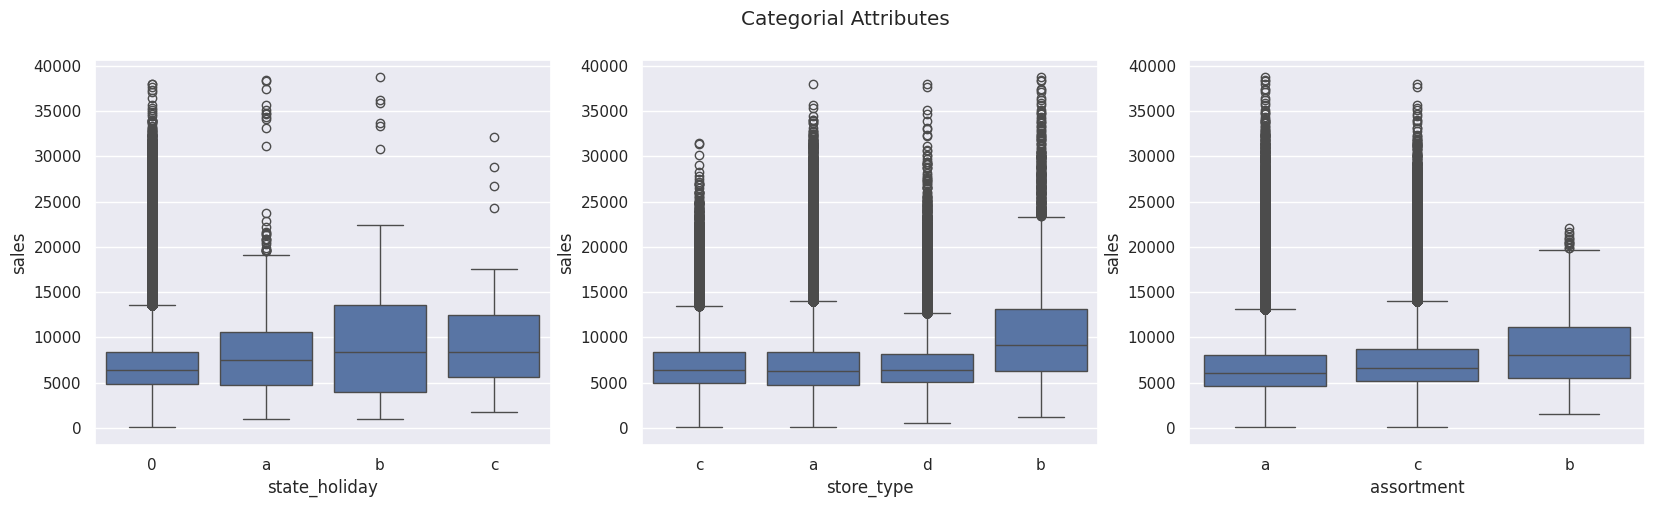

In [16]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.boxplot( ax=axes[0], x='state_holiday', y='sales', data=df1_aux );
sns.boxplot( ax=axes[1], x='store_type',    y='sales', data=df1_aux );
sns.boxplot( ax=axes[2], x='assortment',    y='sales', data=df1_aux );


# 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map

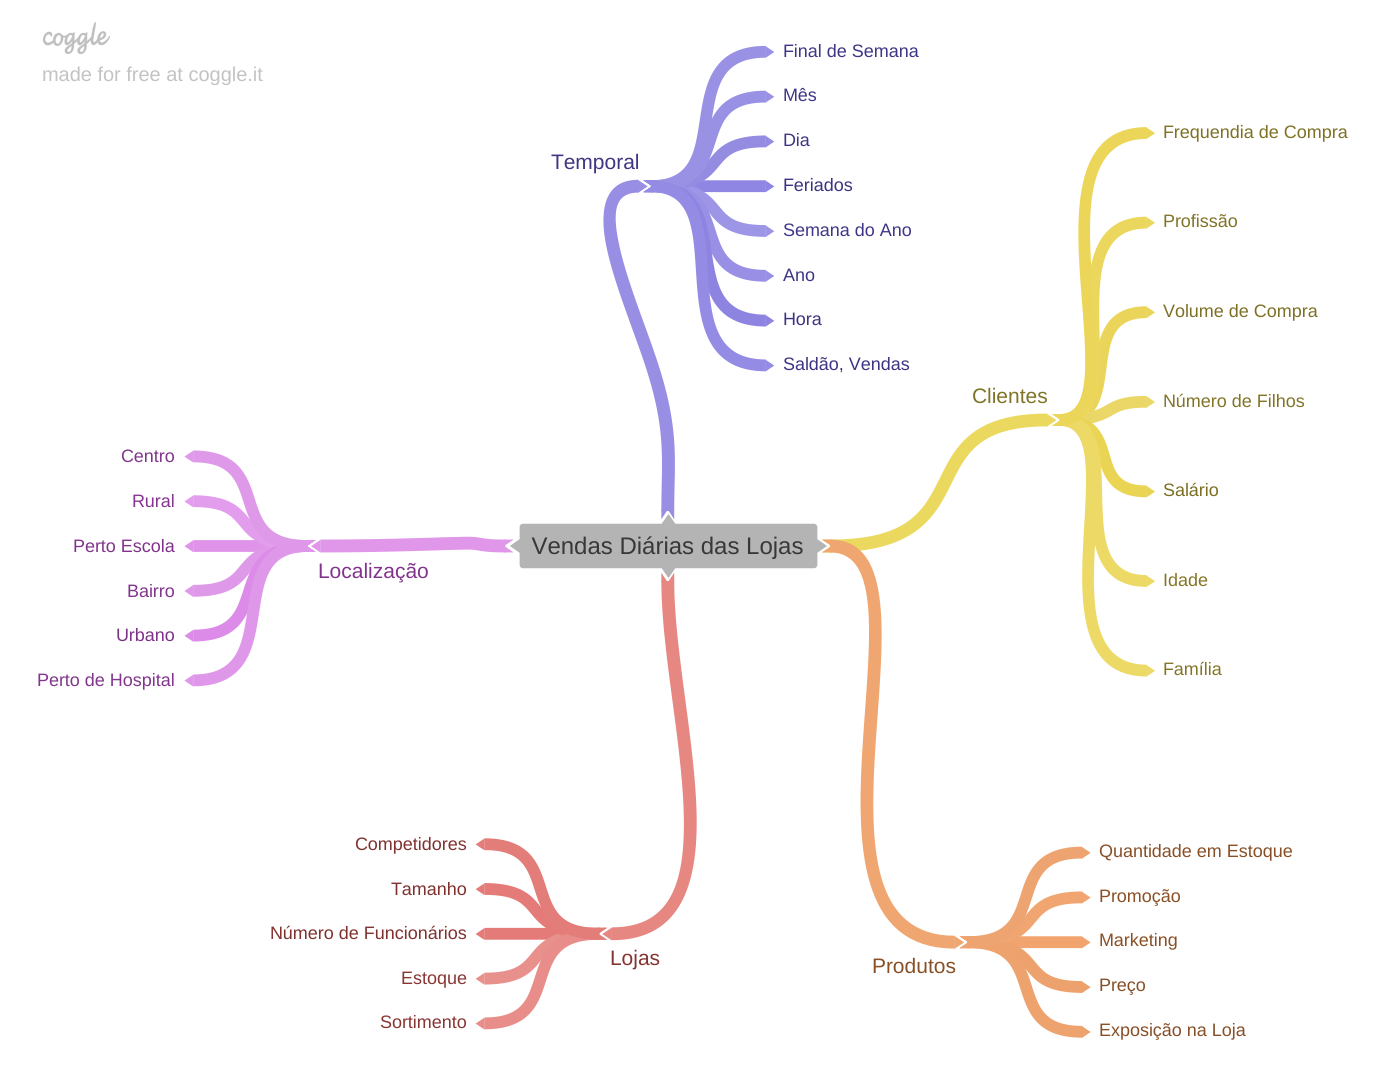

In [18]:
Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

### 2.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 2.4 Create Features

In [19]:
df2 = create_features( df2 )

### 2.4.1 From date column

In [20]:
df2[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
932442,2013-03-18,2013,3,18,12,2013-12
336561,2014-09-15,2014,9,15,38,2014-38
294108,2014-10-31,2014,10,31,44,2014-44
210162,2015-01-24,2015,1,24,4,2015-4
340601,2014-09-11,2014,9,11,37,2014-37


### 2.4.2 From competition_open_since columns

In [21]:
df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
747423,2013-08-30,2011,6,2011-06-01,27
151095,2015-03-18,1995,11,1995-11-01,235
531832,2014-03-12,2010,3,2010-03-01,49
753517,2013-08-25,2015,3,2015-03-01,-19
358434,2014-08-23,2014,4,2014-04-01,4


### 2.4.3 From promo2_since columns

In [22]:
df2[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
372097,2013,5,2013-01-28,2014-08-08,79
980340,2014,40,2014-09-29,2013-02-03,-87
358302,2014,34,2014-08-18,2014-08-23,0
583682,2014,4,2014-01-20,2014-01-24,0
598086,2014,2,2014-01-06,2014-01-11,0


### 2.4.4 From assorment column

In [23]:
df2['assortment'].value_counts()

assortment
basic       512539
extended    449924
extra         7916
Name: count, dtype: int64

### 2.4.5 From state_holiday column

In [24]:
df2['state_holiday'].value_counts()

state_holiday
regular day       939329
public holiday     20260
easter holiday      6690
christmas           4100
Name: count, dtype: int64

## 2.5 Filtering Variables

### 2.5.1 Filtering Lines

In [16]:
df_x = df1[  ( df1['sales'] == 0 ) ]
df_x.shape[0]/df1.shape[0]

0.17140004060269234

In [25]:
df2 = remove_rows( df2 )
df2[ ( df2['sales'] == 0 ) | ( df2['open'] == 0 ) ].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week


### 2.5.2 Filtering Columns

In [26]:
df2 = drop_cols( df2 )
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

# 3.0 Exploratory Data Analysis

In [27]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

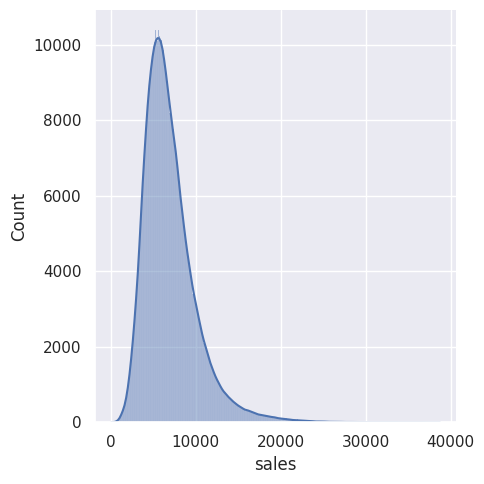

In [28]:
# checking distribuition 
sns.displot( df3['sales'], kde='hist');

### 3.1.2 Numerical Variables

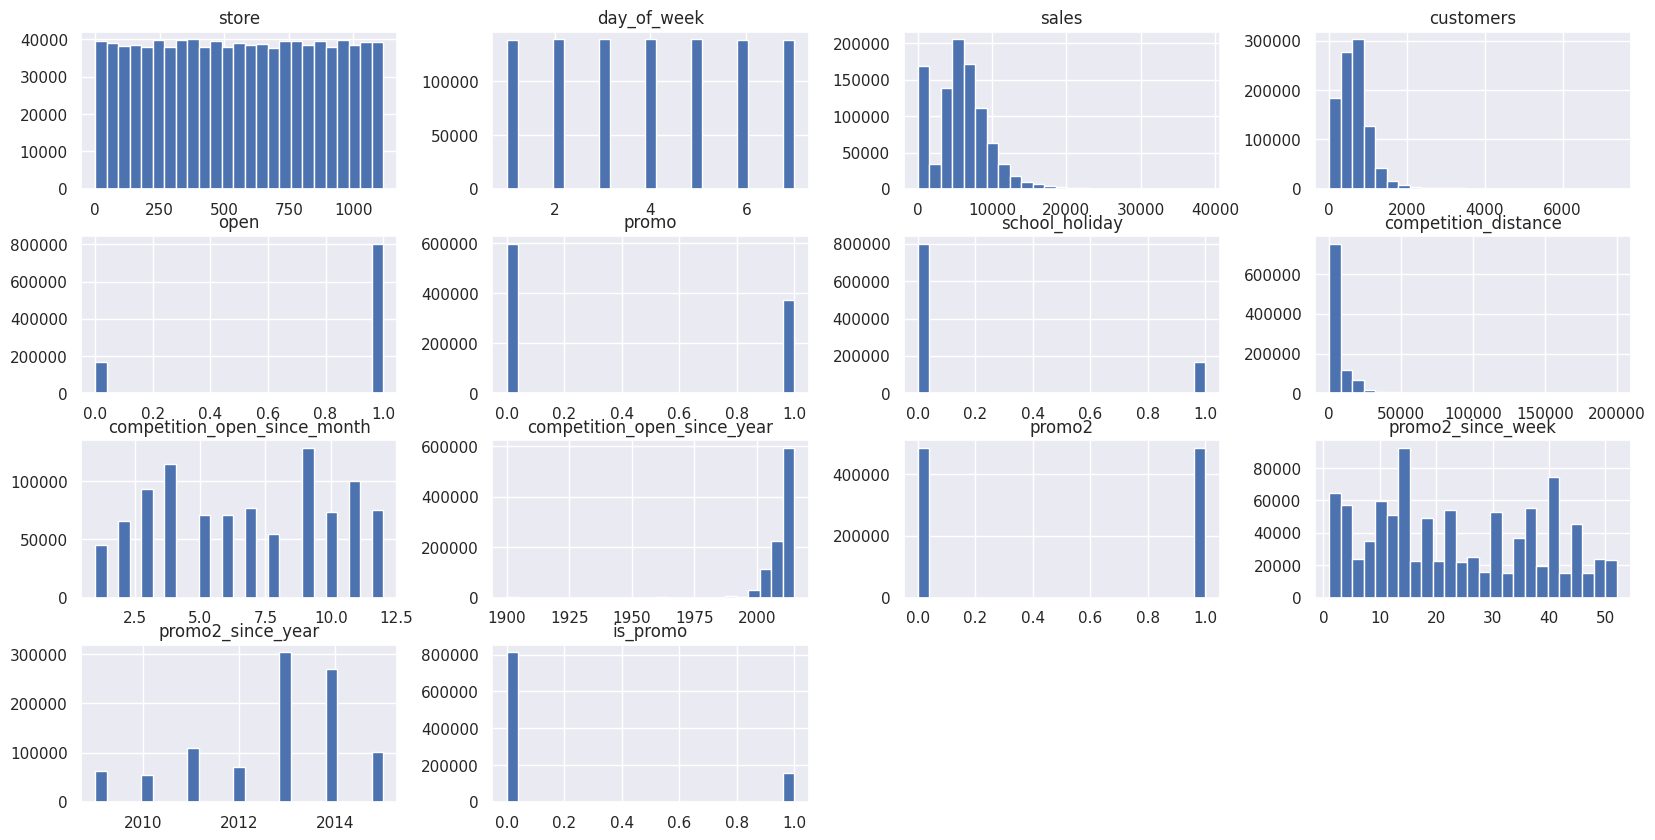

In [29]:
# cheking distribuition
df_num_attributes.hist( bins=25, figsize=(20, 10) );

##### Notas do gráfico: 

**1.** A variável "competition_open_since_month" apresenta vários comportamentos, e quantos mais comportamentos uma variável possui melhor para o aprendizado do modelo.

**2.** Já a variável "day_of_week" apresenta um comportamente constante, não há variação, esse tipo de variável sozinha não serve para o aprendizado modelo

### 3.1.3 Categorical Variables

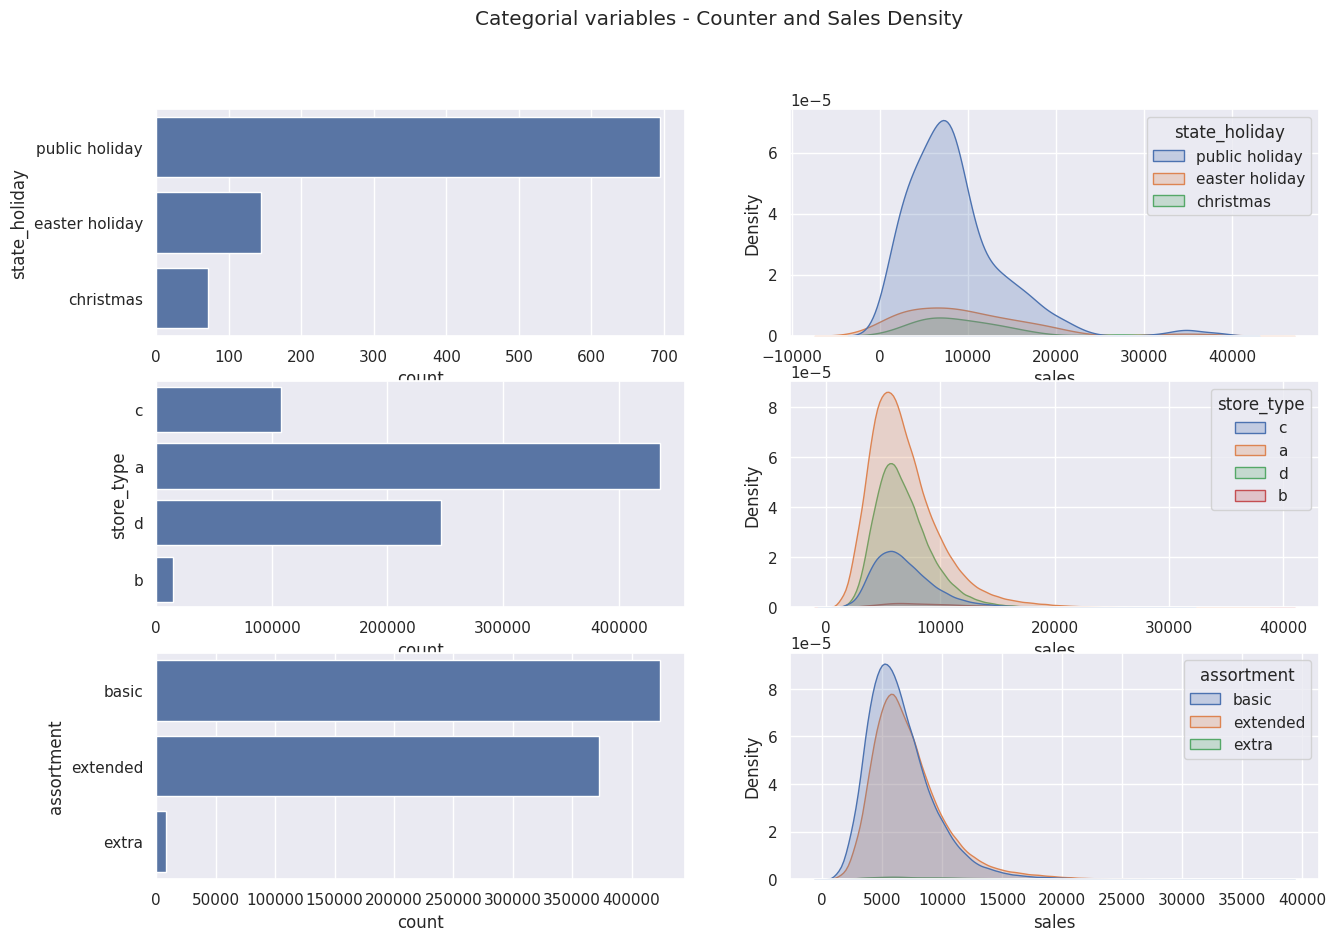

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Categorial variables - Counter and Sales Density')

# state_holiday
sns.countplot( ax=axes[0,0], data=df3[ df3['state_holiday'] !=  'regular day' ]['state_holiday'] );
sns.kdeplot  ( ax=axes[0,1], data=df3[ df3['state_holiday'] !=  'regular day' ][['state_holiday', 'sales']], x='sales',  hue='state_holiday', fill=True );

# store_type
sns.countplot( ax=axes[1,0], data=df3['store_type'] );
sns.kdeplot  ( ax=axes[1,1], data=df3[['store_type', 'sales']], x='sales',  hue='store_type', fill=True );

# assortment
sns.countplot( ax=axes[2,0], data=df3['assortment'] );
sns.kdeplot  ( ax=axes[2,1], data=df3[['assortment', 'sales']], x='sales',  hue='assortment', fill=True );


## 3.2 Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais (STORE)

***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

***ASSORTMENT*** Apresenta comportamento variável na classe "extra", mas com um volume pequeno de dados, portanto, relevância BAIXA para o modelo

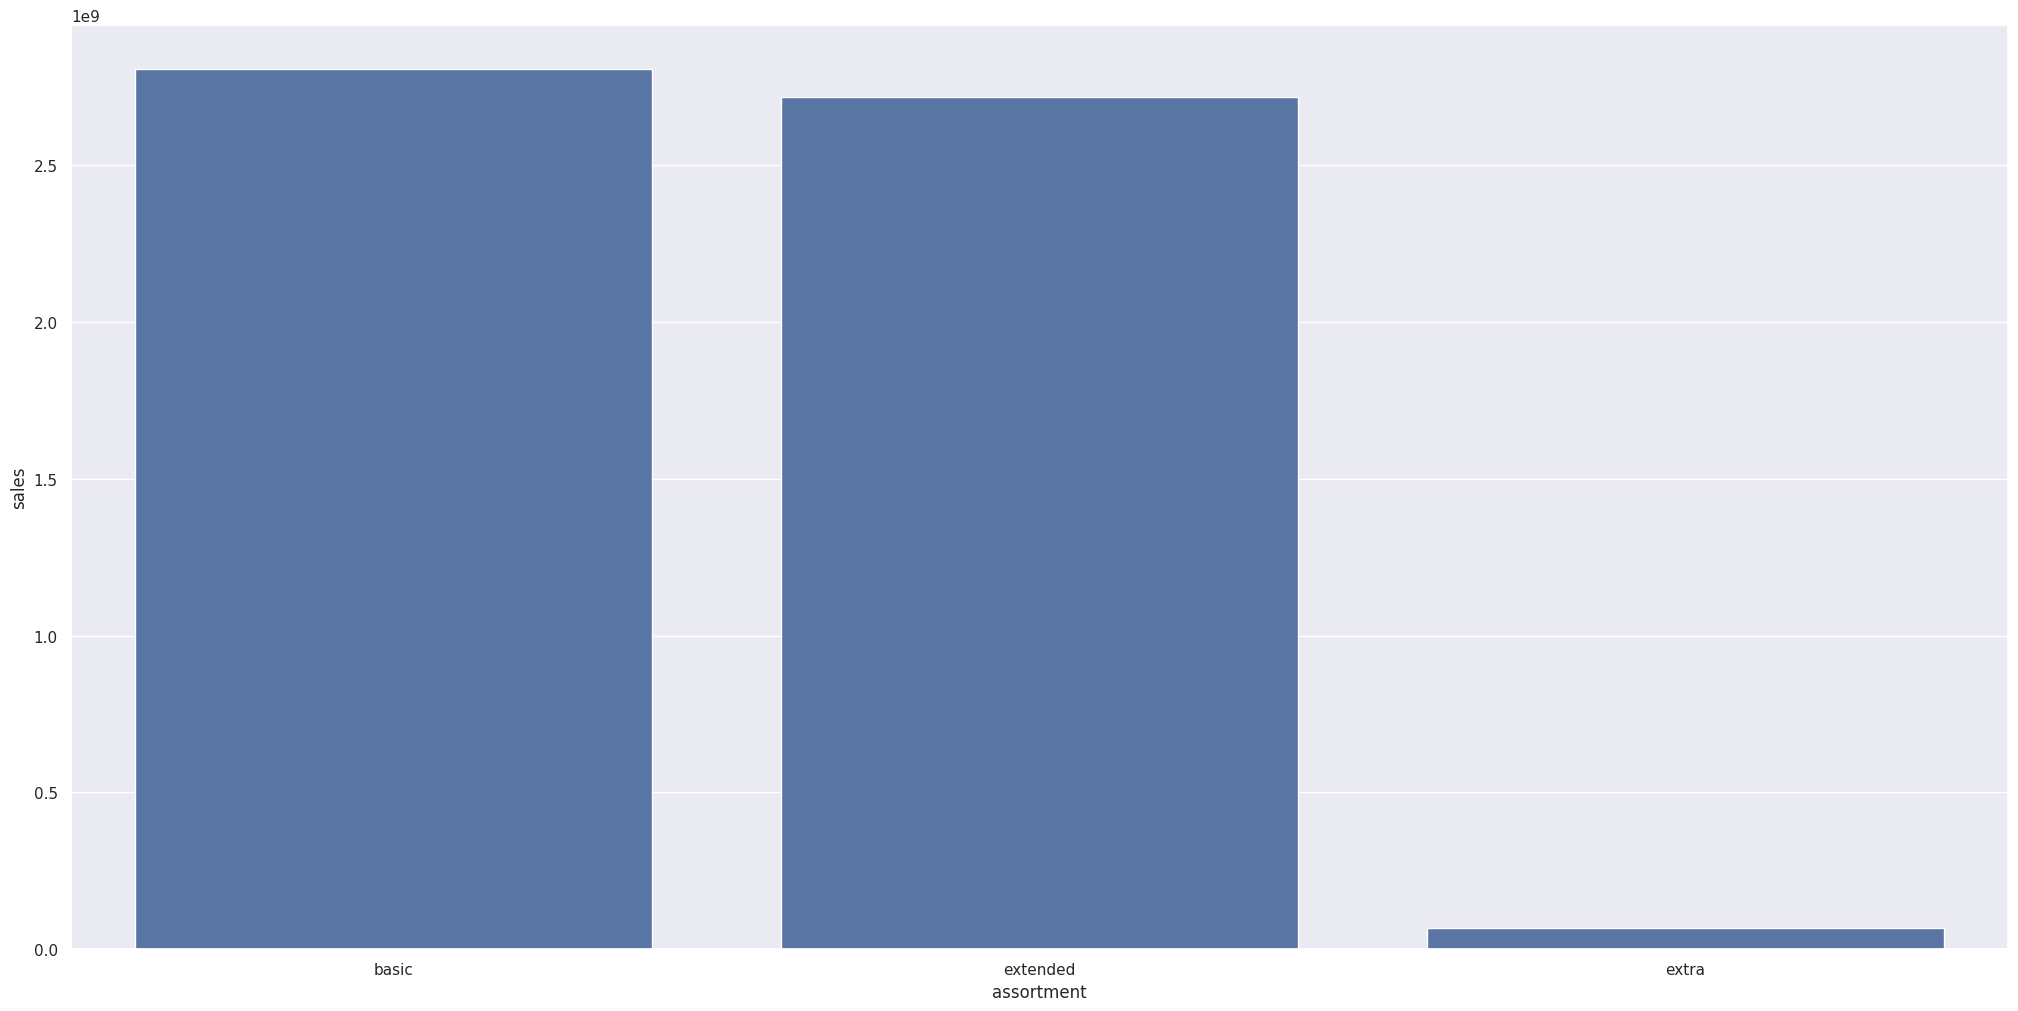

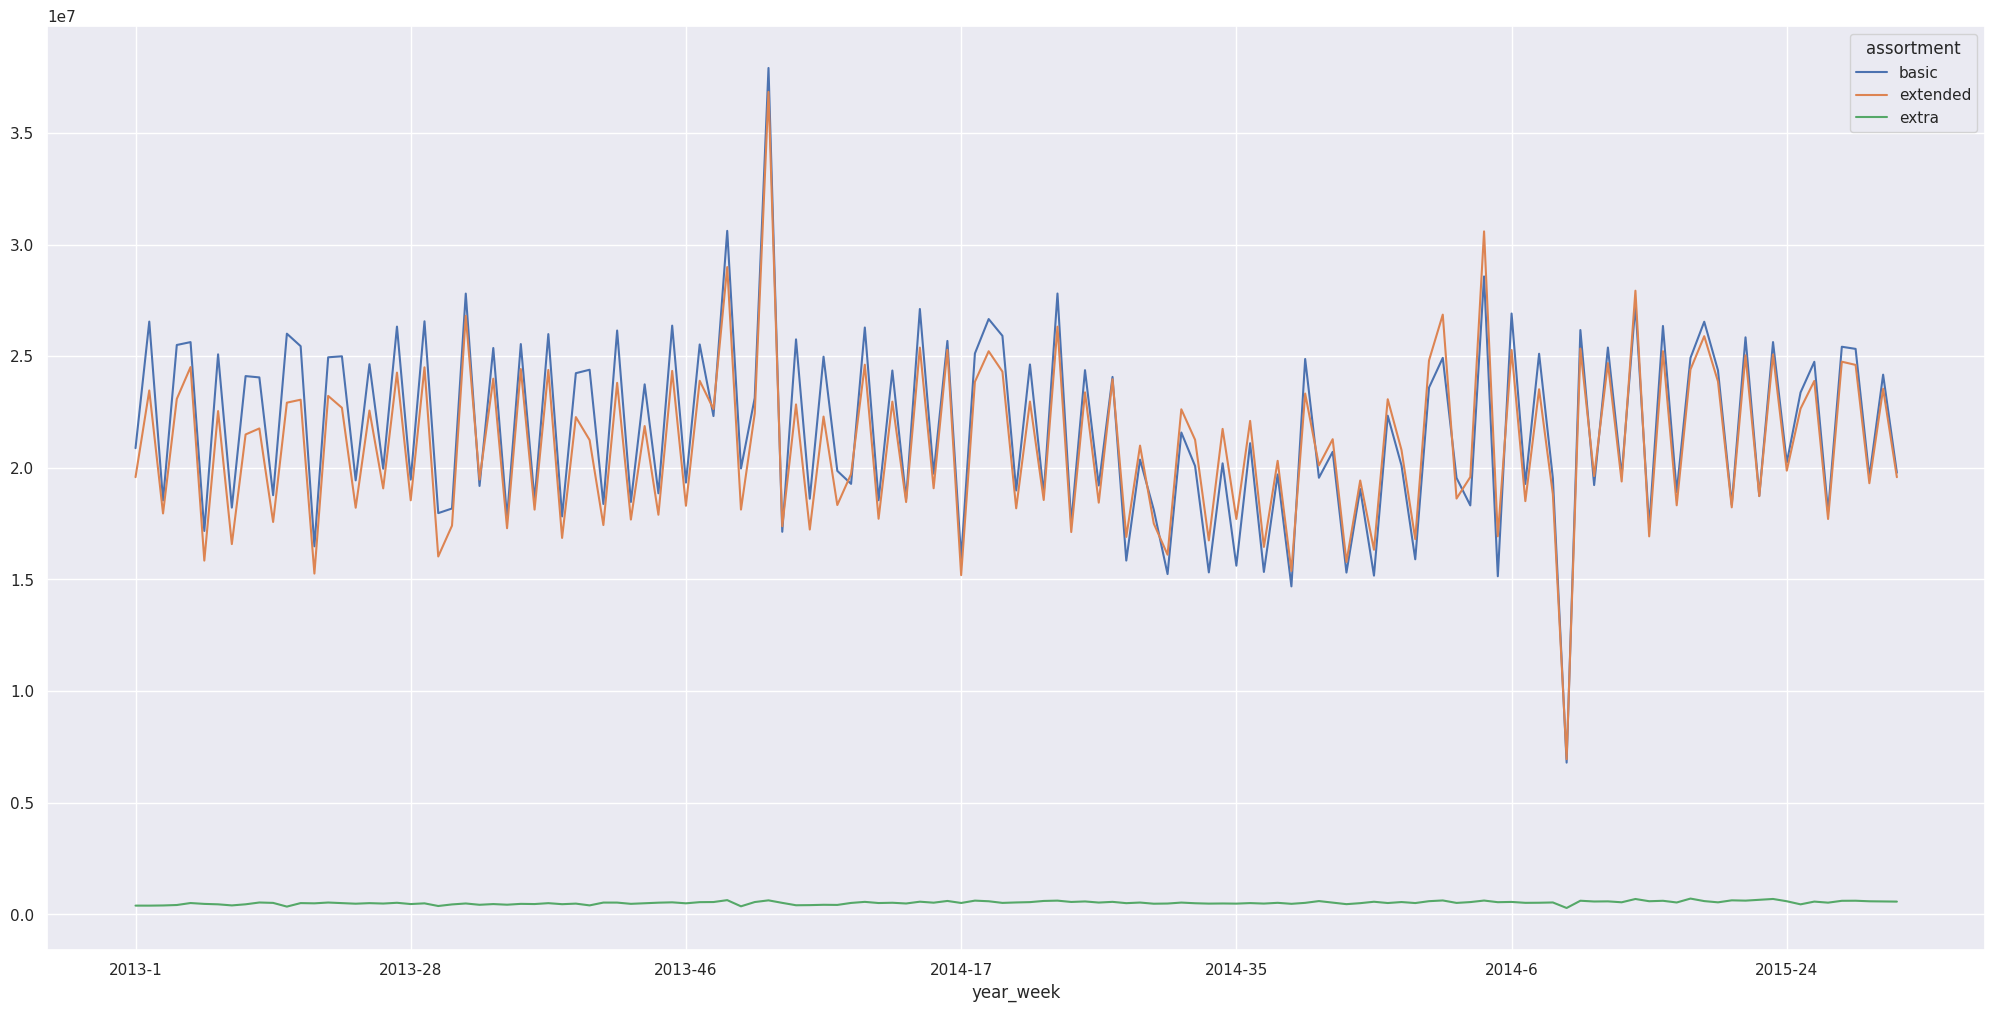

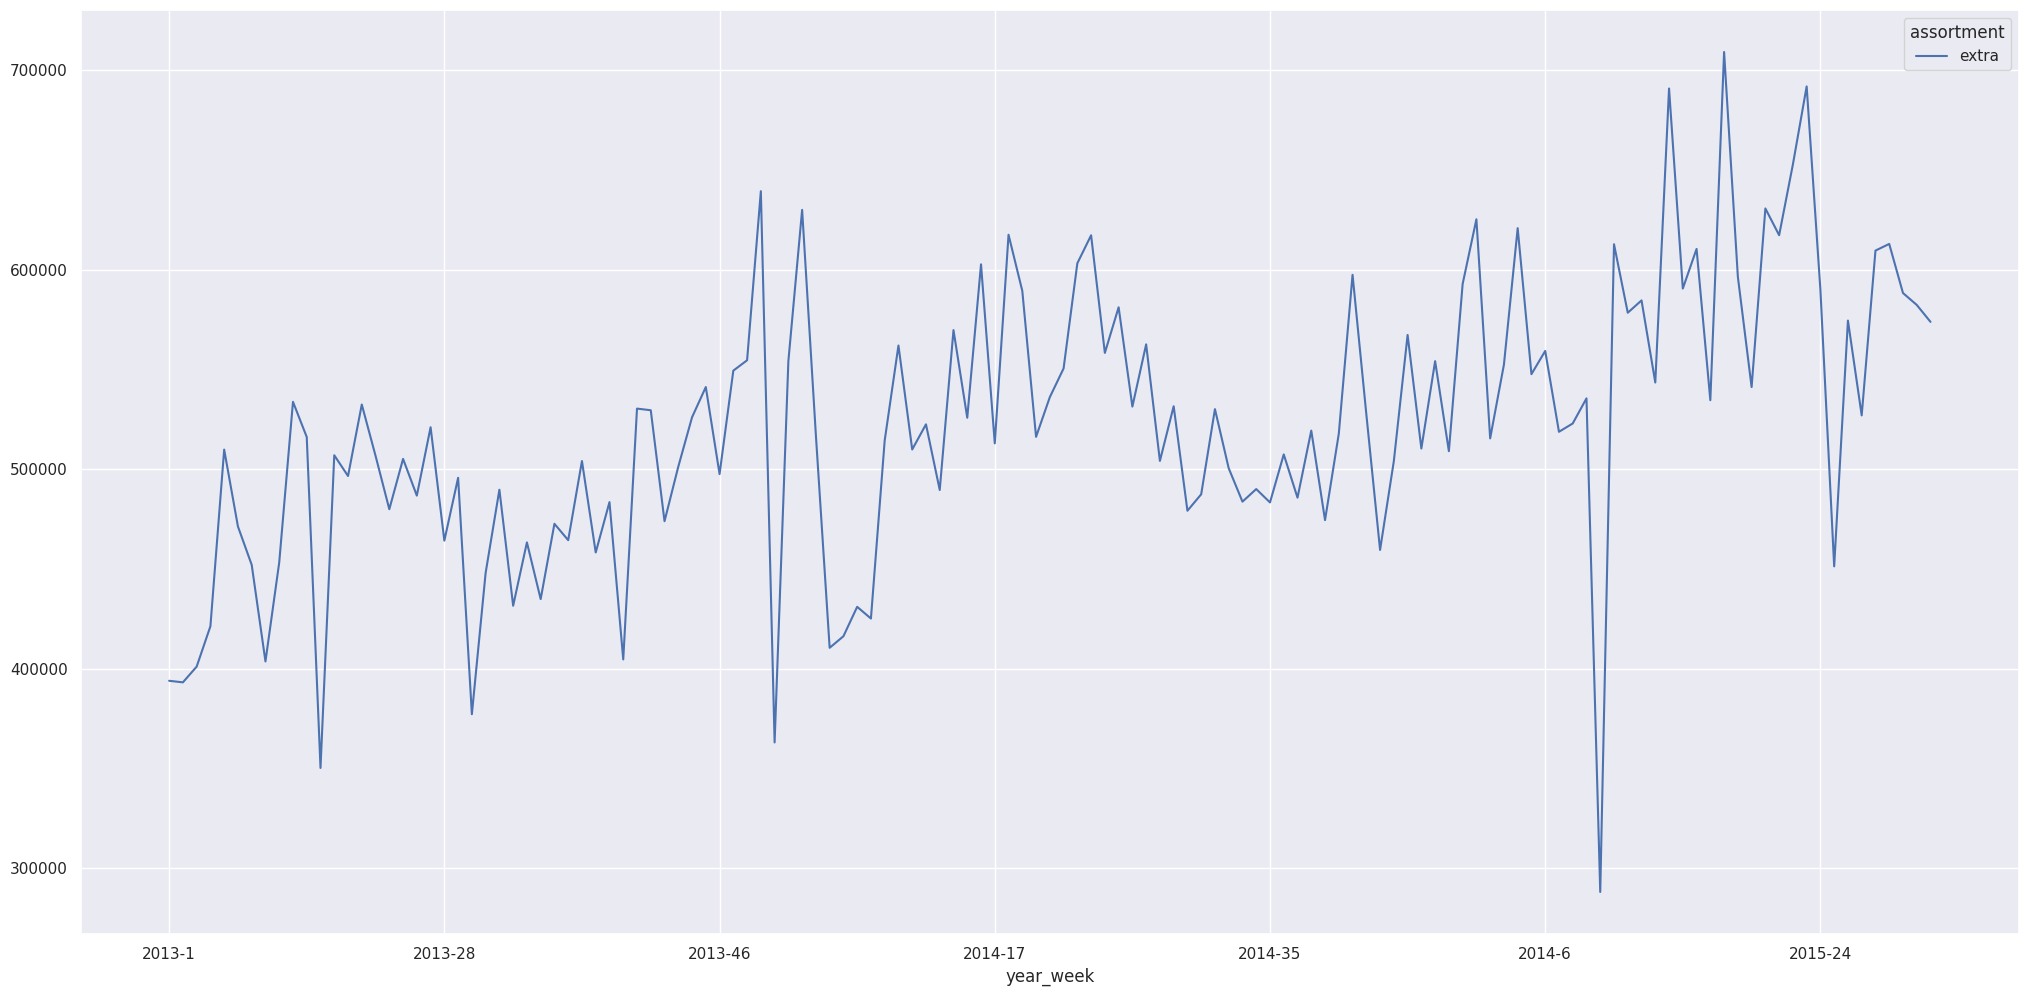

In [31]:
# sales x assortments - total
aux = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux );

# sales x assortments - timeline 
aux2 = df3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

# sales x assortments - only "extra" assortment
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos (STORE)

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

**COMPETITION_DISTANCE** apresenta uma correlação FRACA com a variável resposta

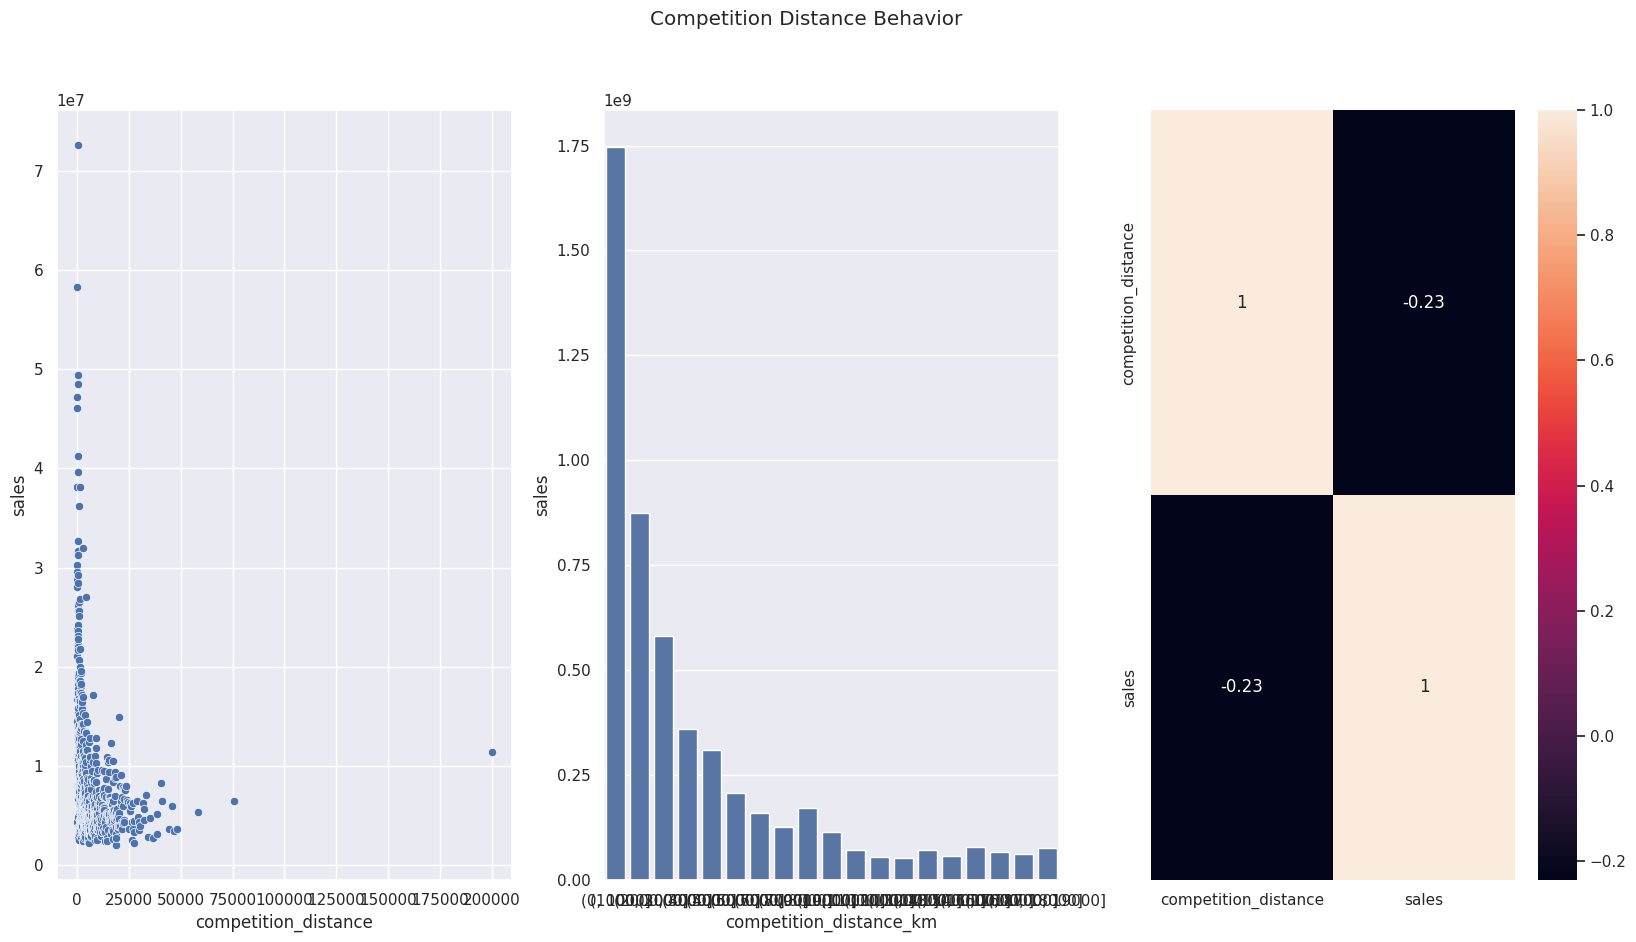

In [32]:

fig, axes = plt.subplots(1, 3, figsize=(20, 10) )
fig.suptitle('Competition Distance Behavior')


# sales x competition_distance - total
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( ax=axes[0], x='competition_distance', y='sales', data=aux1 );


# sales x competition_distance - grouped by km
competition_distance_km = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_km'] = pd.cut( aux1['competition_distance'], bins=competition_distance_km )
aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()
sns.barplot( ax=axes[1], x='competition_distance_km', y='sales', data=aux2 );


# sales x competition_distance corr method
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[2] );


### H3 - Lojas com competidores a mais tempo deveriam vender mais (STORE)



**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

**COMPETITION_TIME_MONTH** possui um correlação com a variável resposta muito próxima de ZERO, portanto, BAIXA CORRELAÇÃO

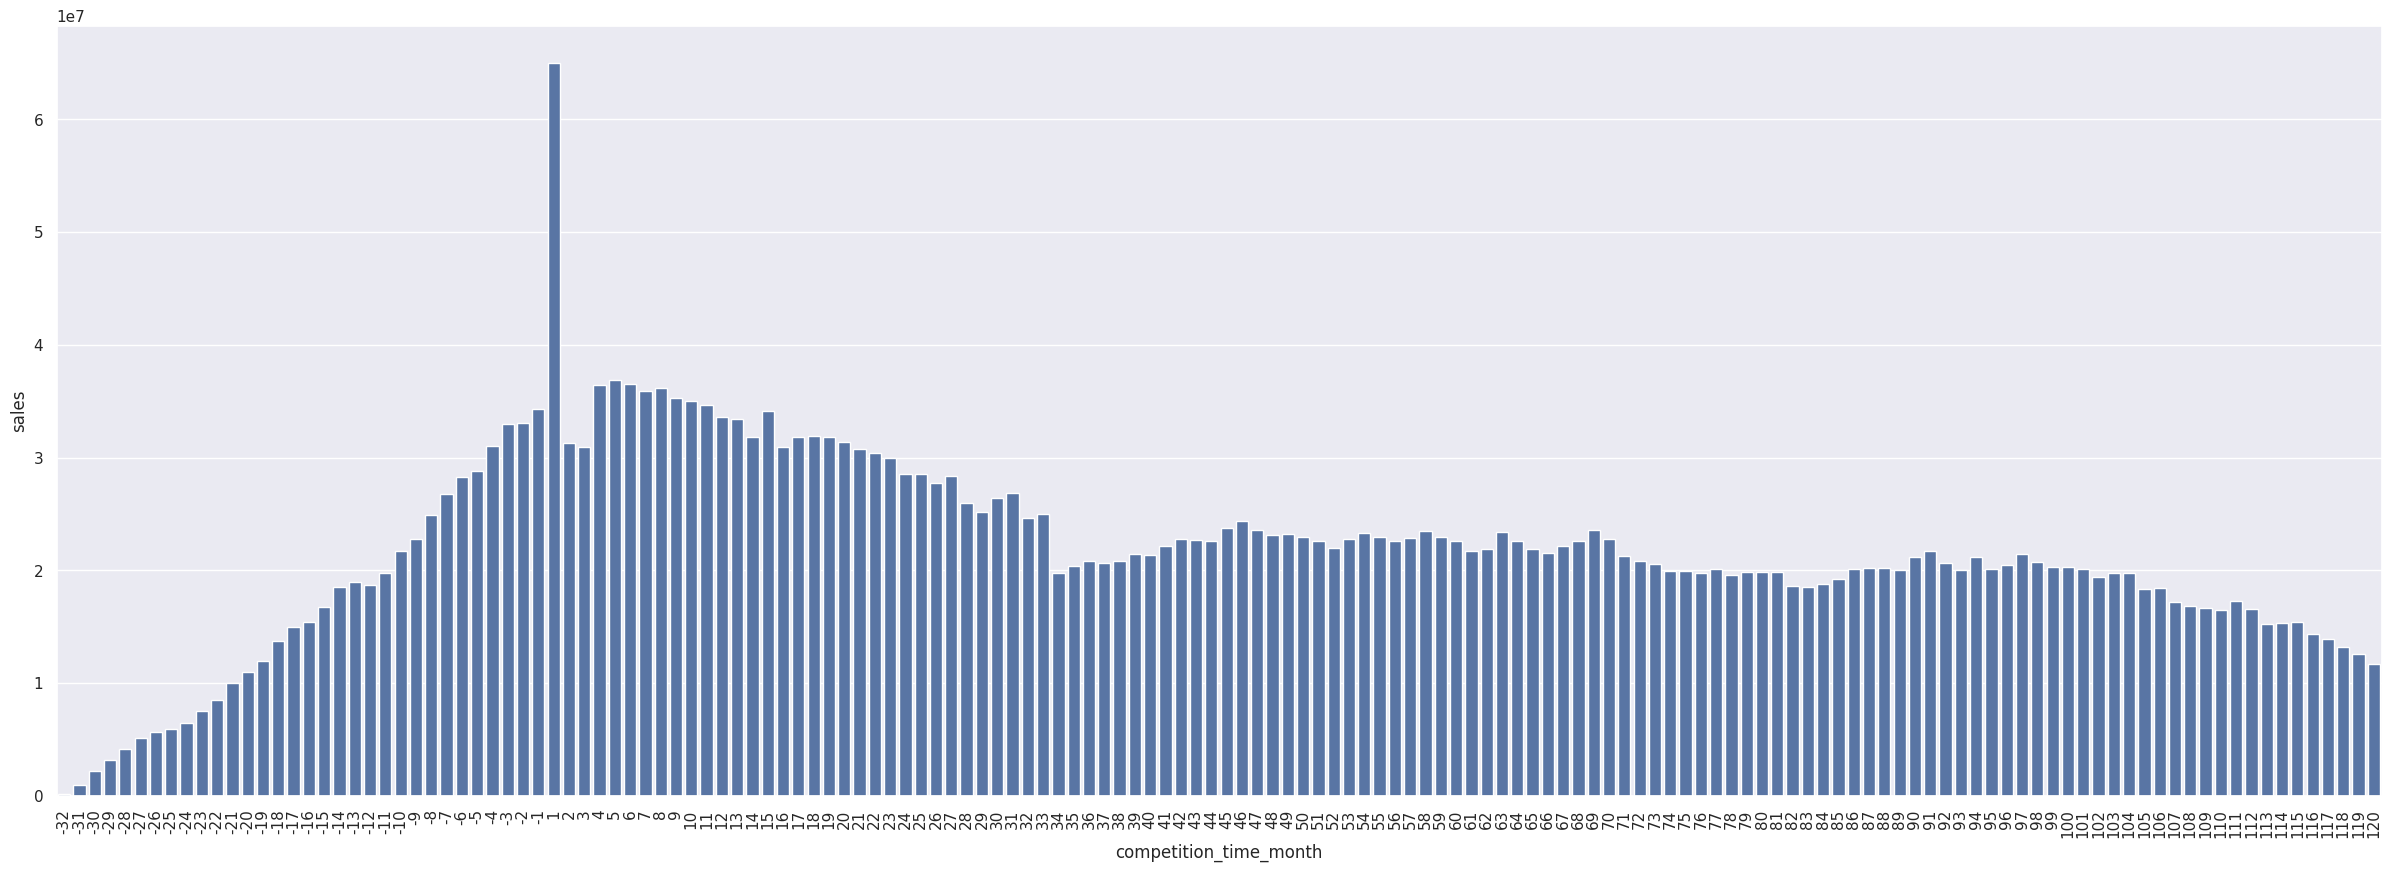

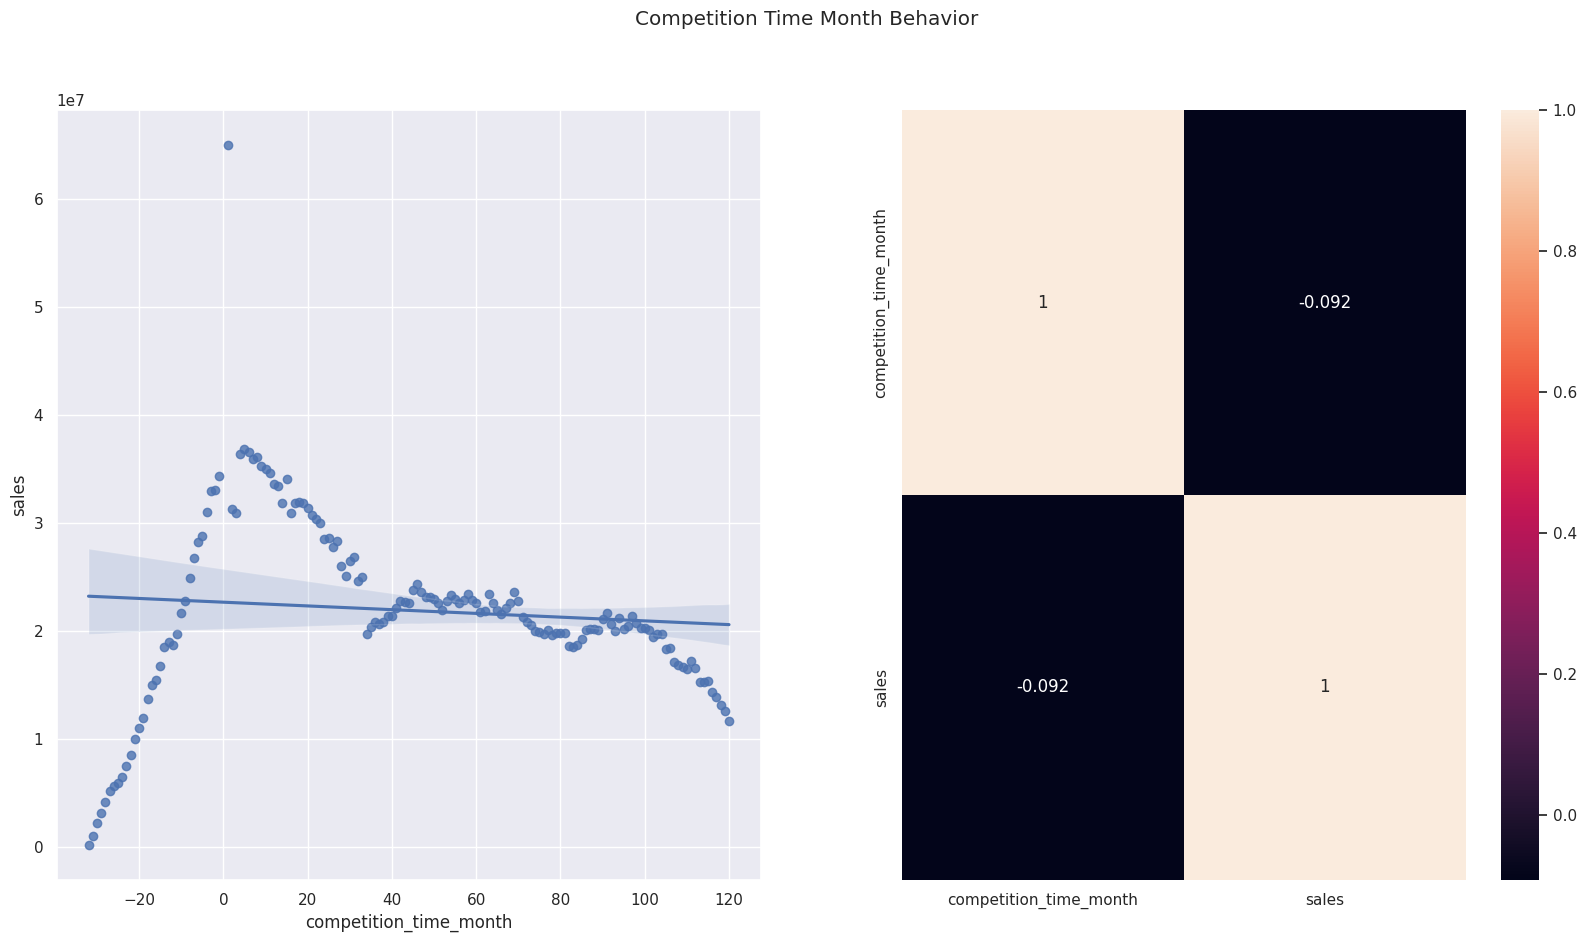

In [33]:
aux1 = df3[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux1 = aux1[ ( aux1['competition_time_month'] != 0 ) & ( aux1['competition_time_month'] <= 120 ) ]

plt.figure(figsize=(30,10));
plt.xticks( rotation='vertical');
sns.barplot( x='competition_time_month', y='sales', data=aux1 );

fig, axes = plt.subplots(1, 2, figsize=(20, 10) )
fig.suptitle('Competition Time Month Behavior')

# sales x competition_time_month 
sns.regplot( x='competition_time_month', y='sales', data=aux1, ax=axes[0] );

# sales x competition_distance corr method
sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)





**FALSA** Lojas com PROMOÇÔES ATIVAS A MAIS TEMPO vendem MENOS depois de um certo período de promoção

**PROMO2_TIME_WEEK** possui uma correlação FRACA com a variável resposta

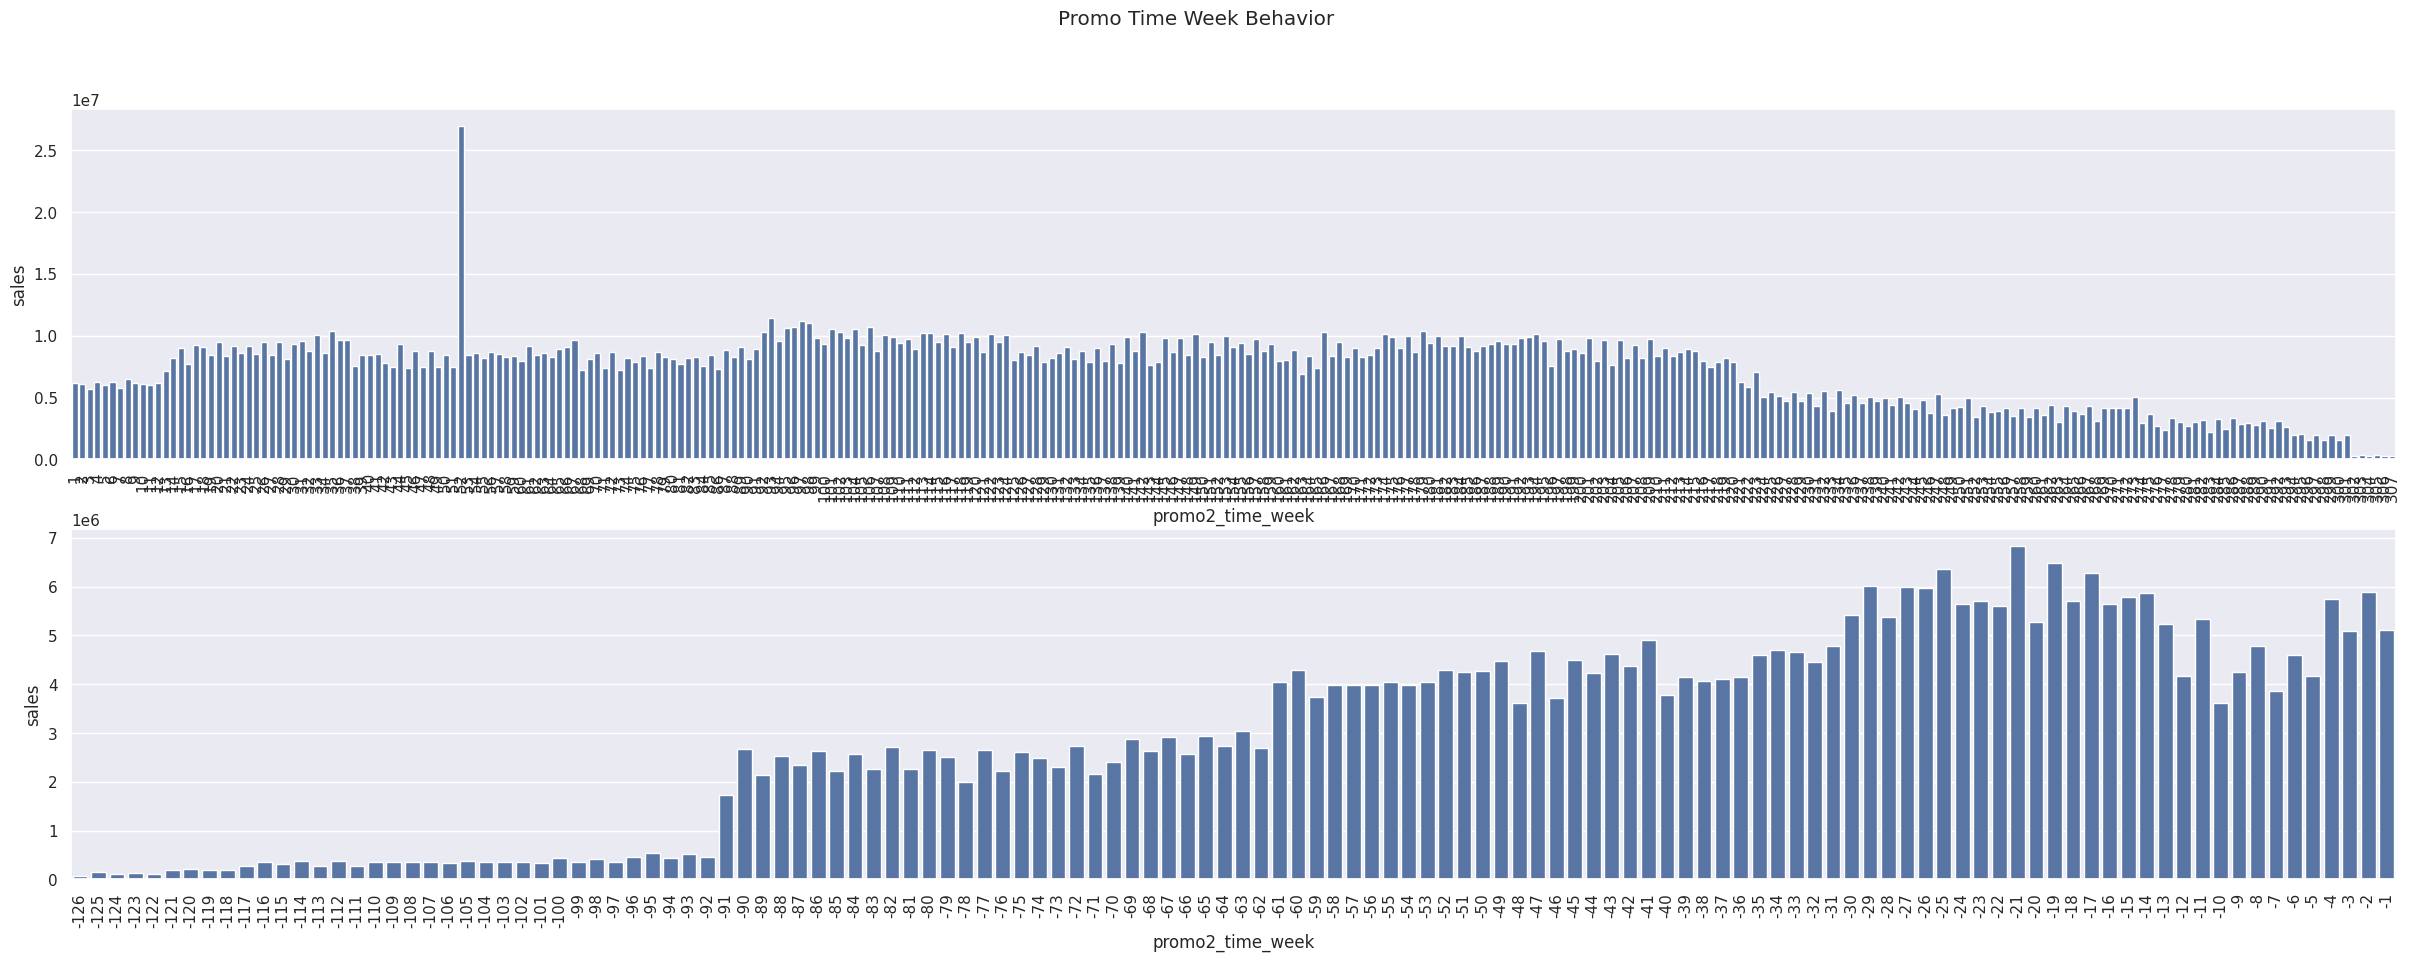

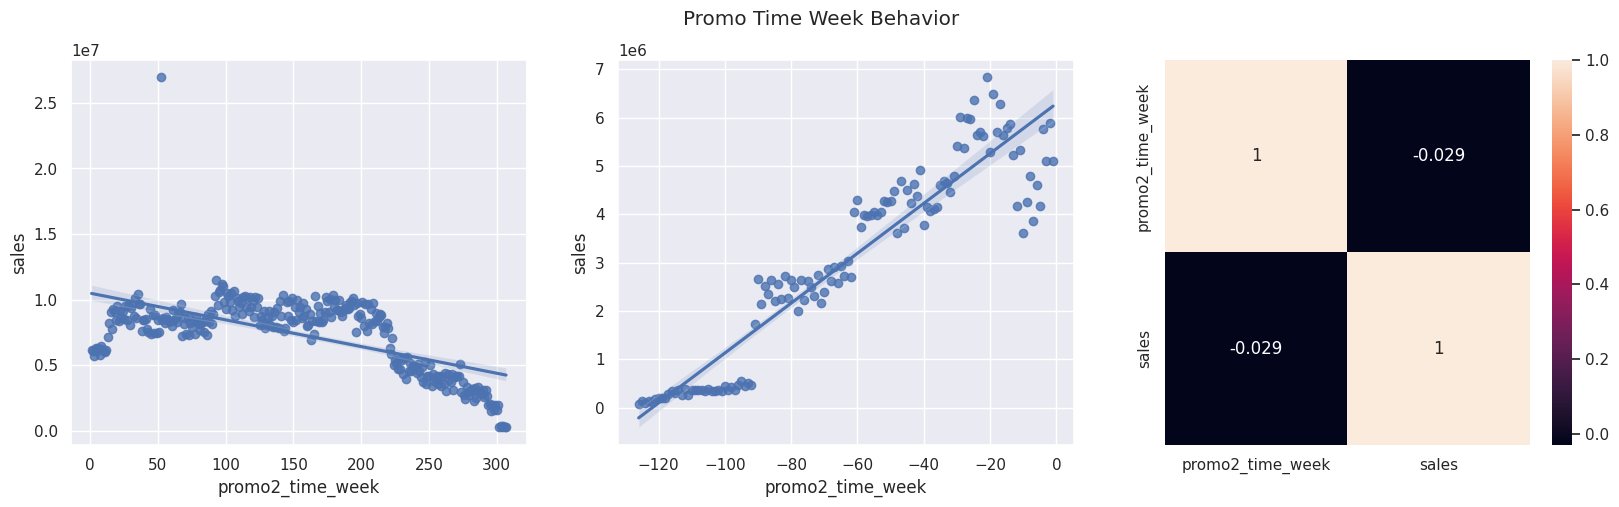

In [34]:
aux1 = df3[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
#sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

# extended promo
aux2 = aux1[ aux1['promo2_time_week'] > 0 ] 

# regular promo
aux3 = aux1[ aux1['promo2_time_week'] < 0 ] 

fig, axes = plt.subplots(2, 1, figsize=(30, 10),  )
fig.suptitle('Promo Time Week Behavior')

axes[0].xaxis.set_tick_params( rotation=90 )
axes[1].xaxis.set_tick_params( rotation=90 )


sns.barplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.barplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Promo Time Week Behavior')

sns.regplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.regplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### <s> H5 - Lojas com mais dias de promoção deveriam vender mais (PRODUCT) </s>

**ON HOLD** Será necessária a criação de uma variável com a quantidade de dias em promoção. Fica para a próxima rodada do CRISP-DS

### H6 - Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)

**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

**PROMO E PROMO2** aprensentam o mesmo comportamente em relação as vendas, portanto, ambas apresentam um correlação FRACA com a variável resposta

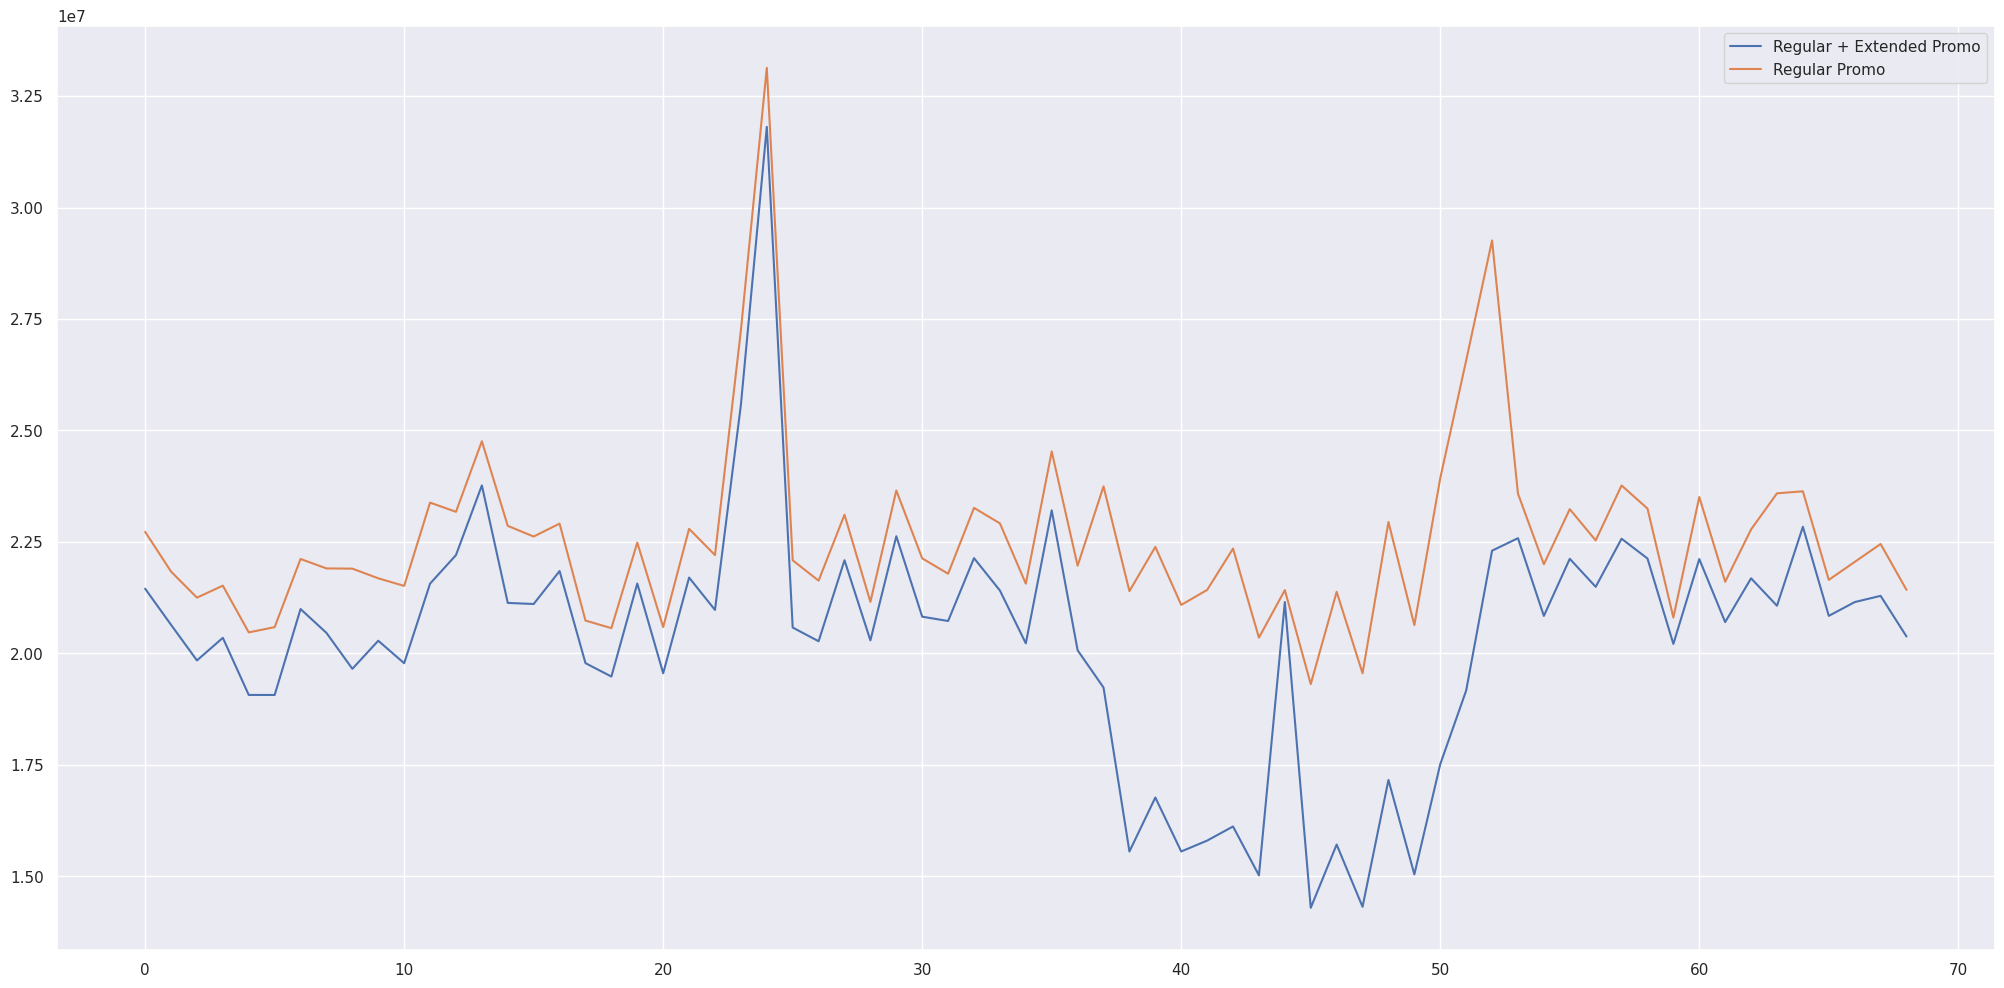

In [35]:
# regular and extended promo
aux1 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 1 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 0 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular + Extended Promo', 'Regular Promo'] );

### H7 -  Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**FALSA**, Lojas abertas durante o feriado de Natal vendem MENOS

**STATE_HOLIDAY** possui comportamentos distintos entre os tipos de feriados e por isso ter uma correlação FORTE com a variável resposta

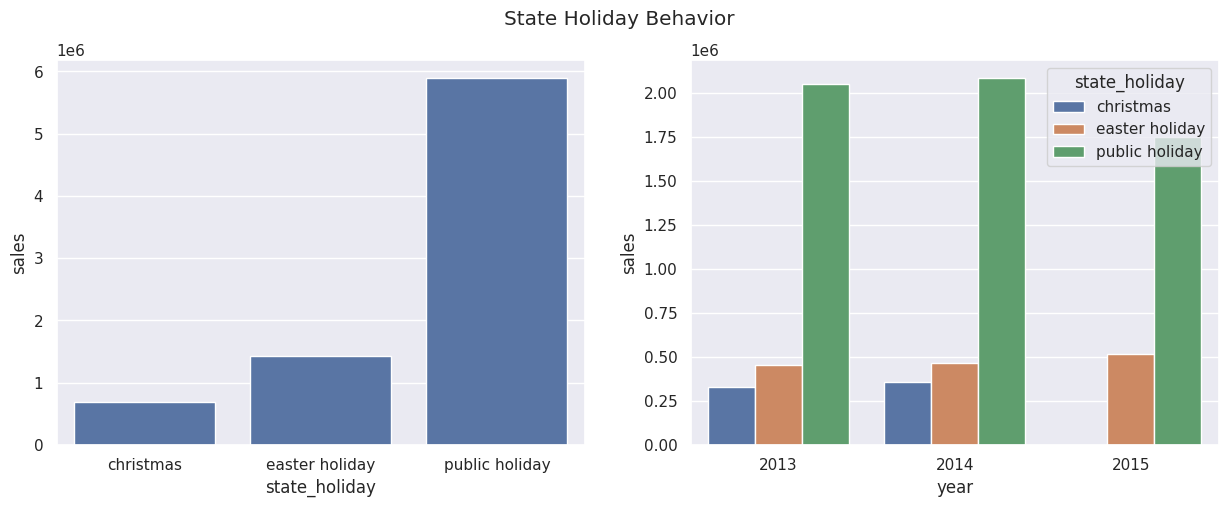

In [36]:
aux1 = df3[ df3['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
aux2 = df3[ df3['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5) )
fig.suptitle('State Holiday Behavior')

sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axes[0] );
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axes[1] );



### H8 - Lojas deveriam vender mais ao longo dos anos (TIME)

**FALSA** Lojas vendem MENOS ao longo dos anos

**YEAR** Possui uma correlação FORTE com a variável resposta

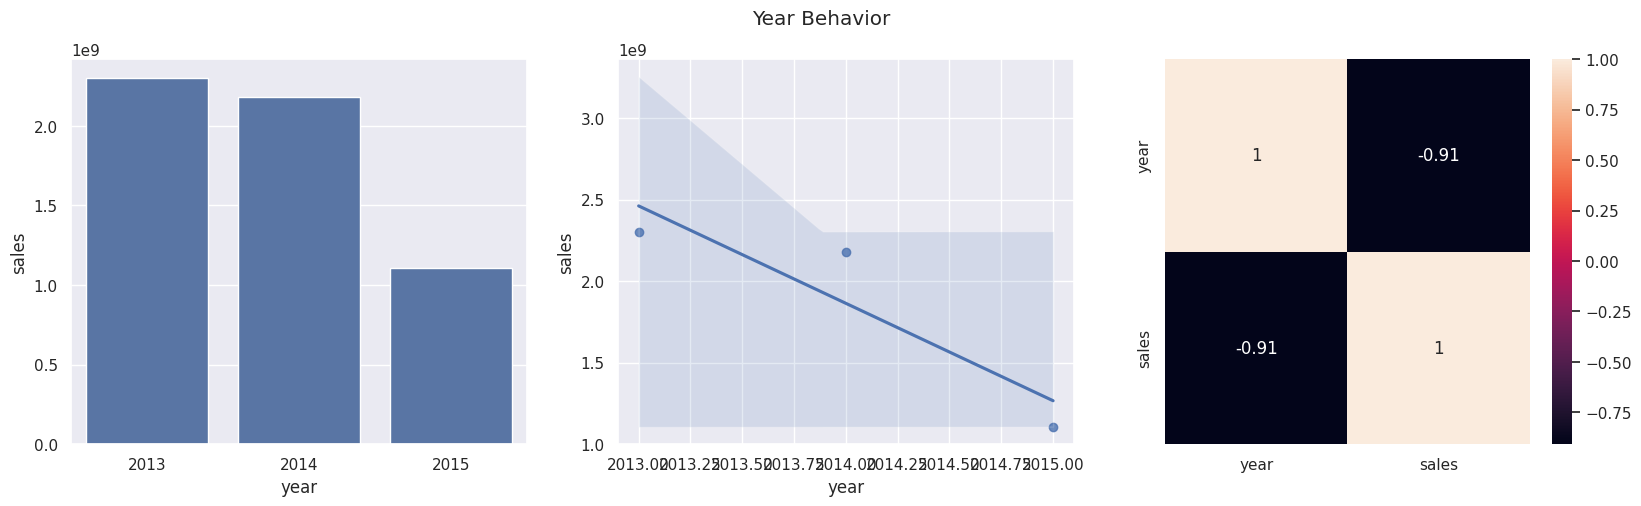

In [37]:
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Year Behavior')

sns.barplot( x='year', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='year', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### H9 - Lojas deveriam vender mais no segundo semestre do ano (TIME)

**FALSA** Lojas vendem MENOS no segundo semestre do ANO

**MONTH** possui uma ALTA correlação com a variável resposta

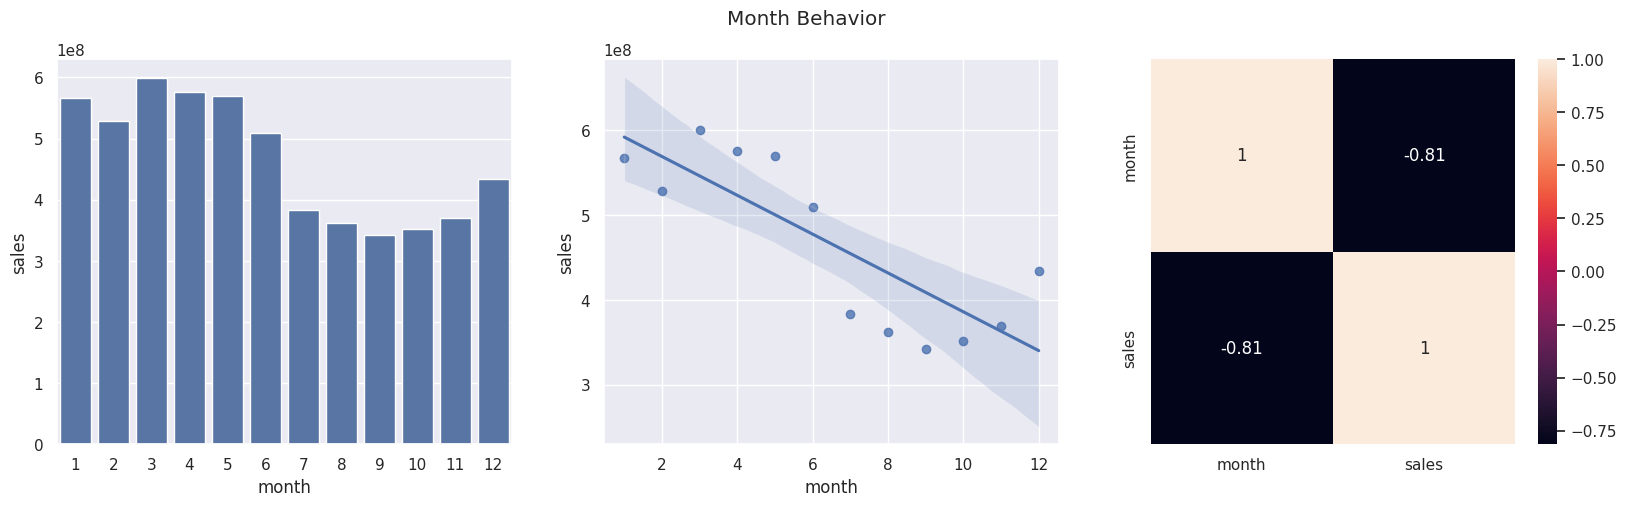

In [38]:
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Month Behavior')

sns.barplot( x='month', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='month', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

**DAY** possui uma correlação MÉDIA com a variável resposta

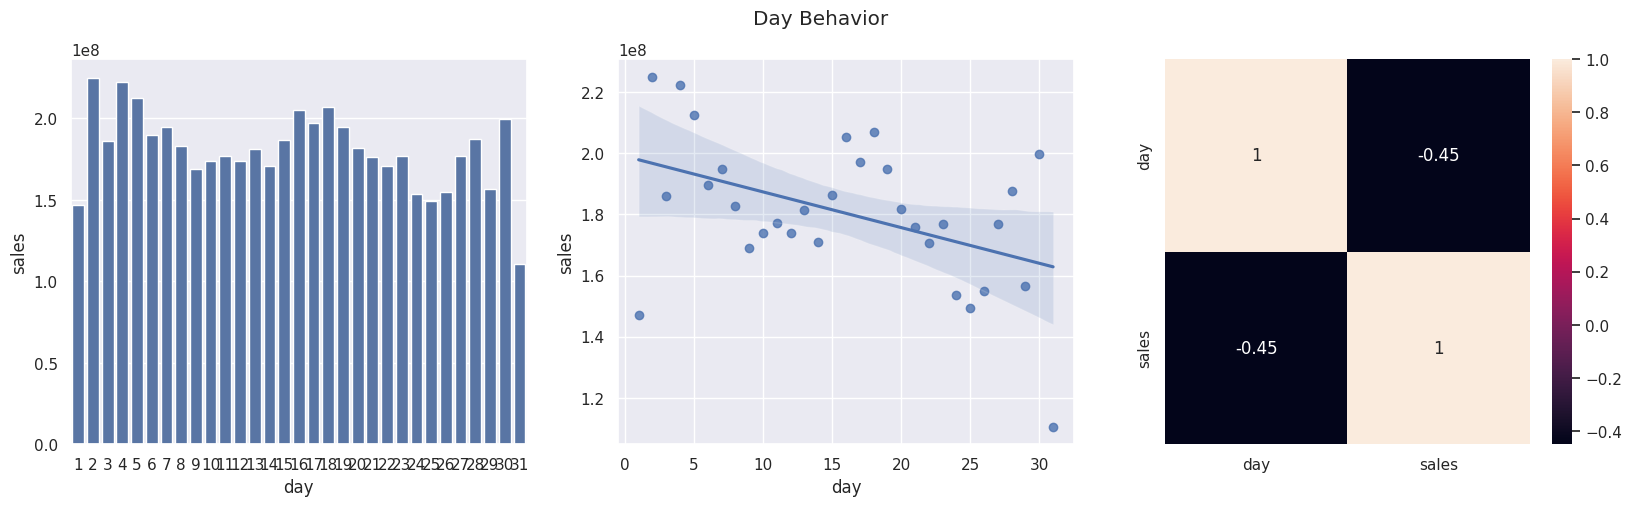

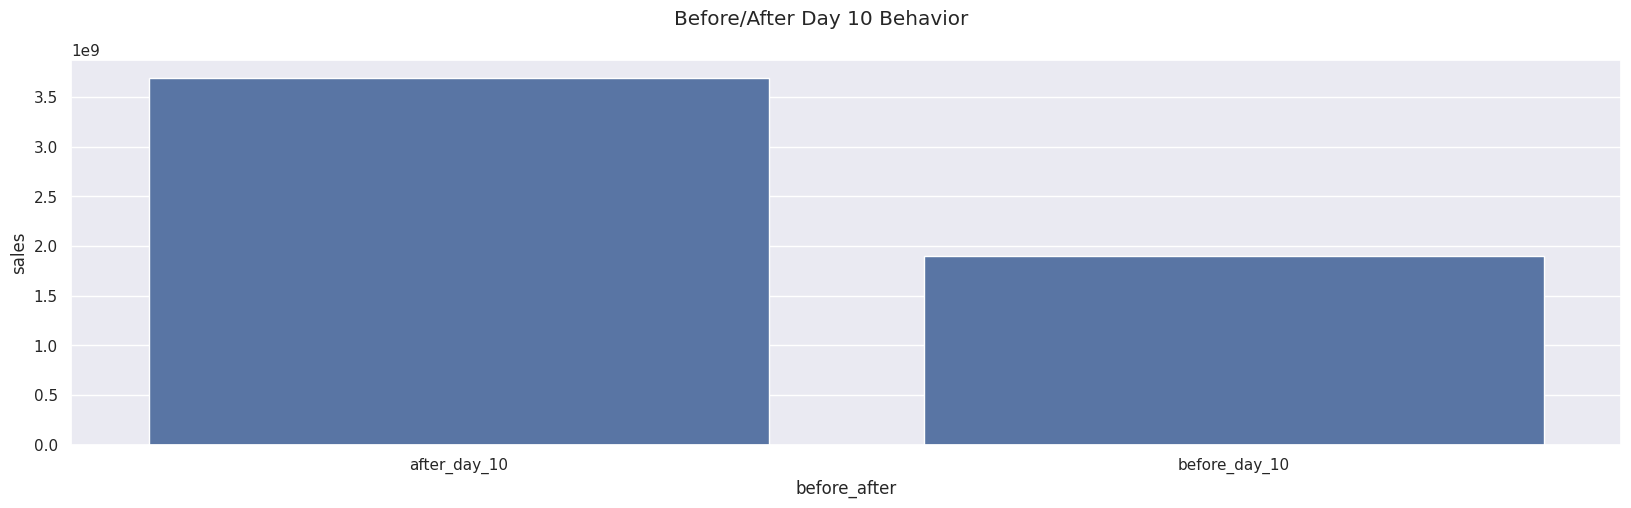

In [39]:
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day Behavior')

sns.barplot( x='day', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Before/After Day 10 Behavior')

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11 -  Lojas deveriam vender menos nos finais de semana (TIME)

**VERDADEIRA** Lojas vendem MENOS nos finais de semana

**DAY_OF_WEEK** possui uma correlação ALTA com a variável resposta

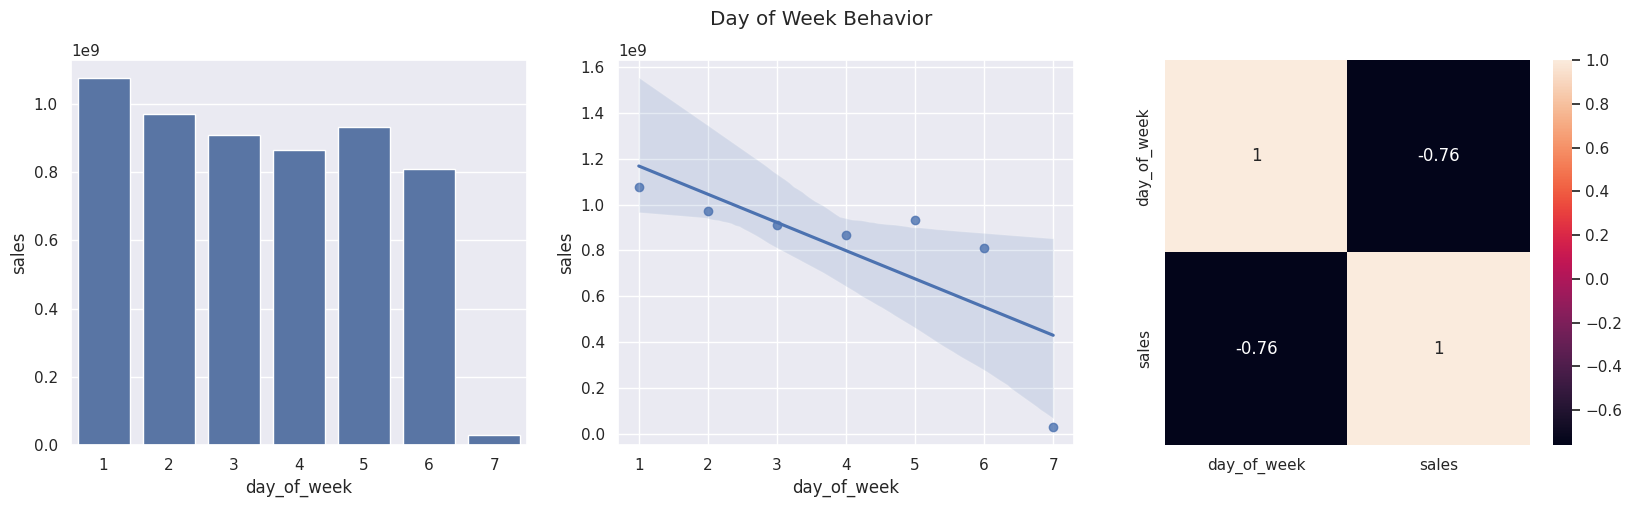

In [40]:
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day of Week Behavior')

sns.barplot( x='day_of_week', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day_of_week', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H12 - Lojas deveriam vender menos durante os feriados escolares (TIME)

**VERDADEIRA** Lojas vendem MENOS durante  os feriados escolares, exceto mês de agosto

**SCHOOL_HOLIDAY** possui uma correlação ALTA com a variável resposta, no entanto, possui pouca variação de comportamento

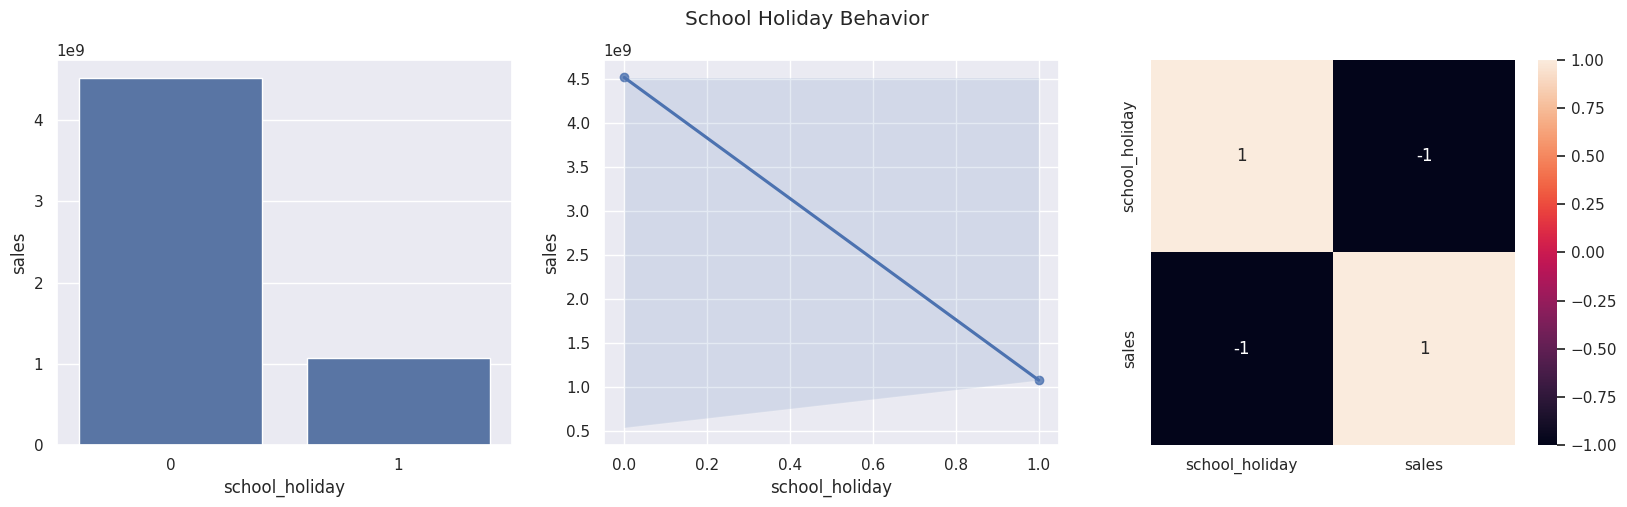

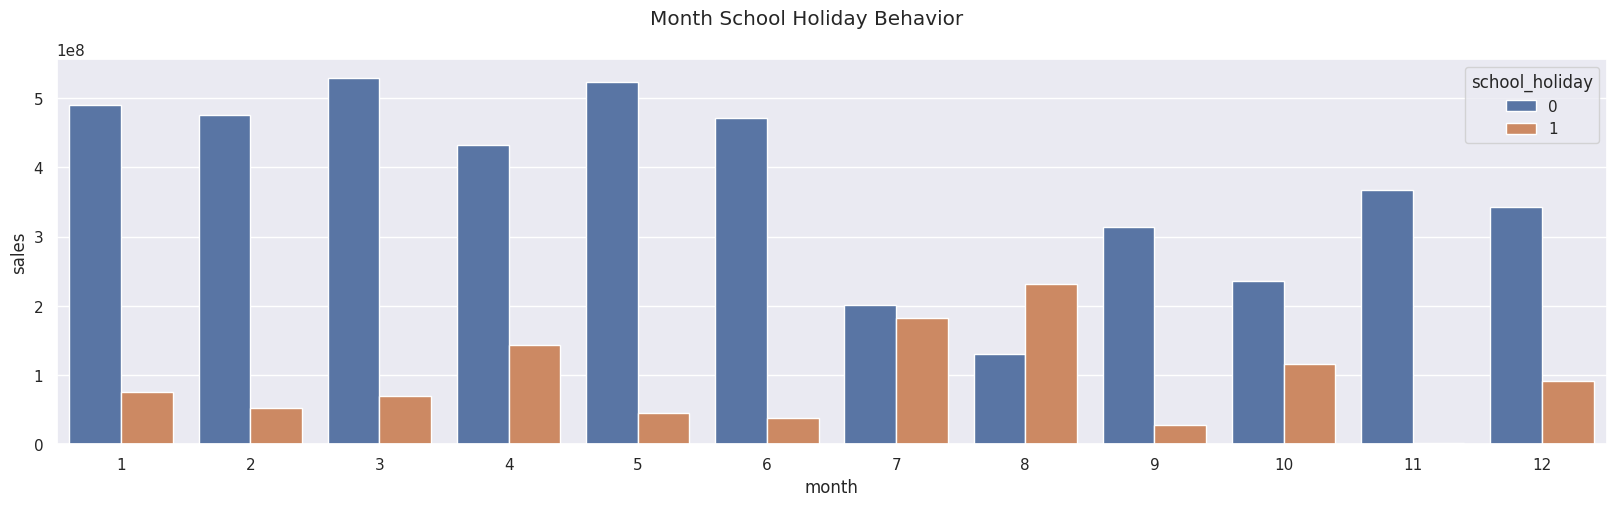

In [41]:
aux1 = df3[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('School Holiday Behavior')

sns.barplot( x='school_holiday', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


aux2 = df3[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Month School Holiday Behavior')

sns.barplot( x='month', hue='school_holiday', y='sales', data=aux2 );

### 3.2.1 Resumo das Hipóteses

In [42]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

<Axes: >

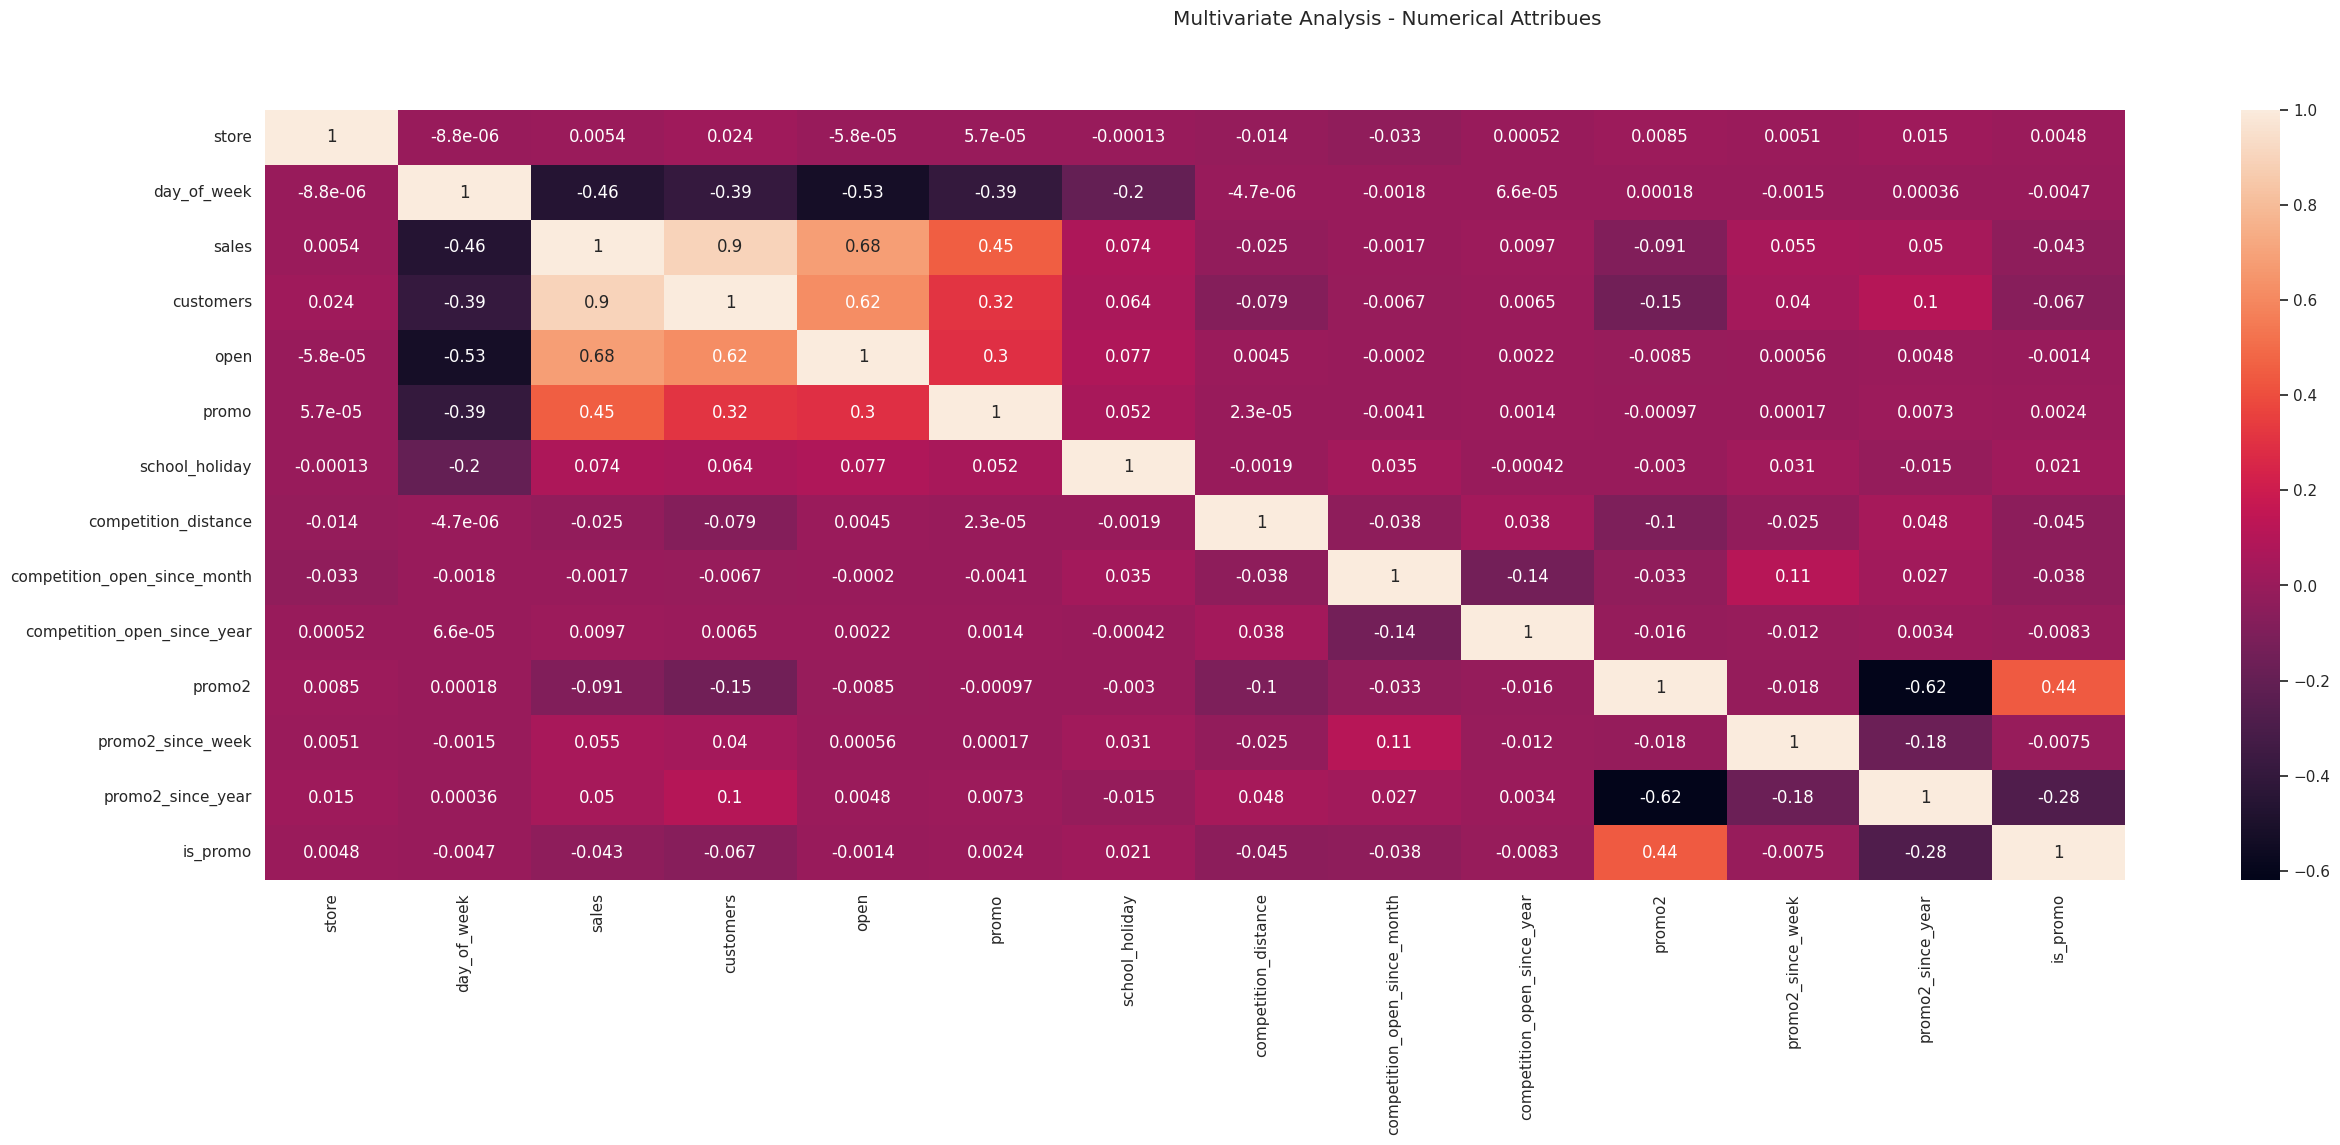

In [43]:
correlation = df_num_attributes.corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 10) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ')

sns.heatmap( correlation, annot=True )

### 3.3.2 Categorical Attributes

In [44]:
# create a dataframe with new categorical columns
cat = df3.select_dtypes( include='object' )
cat.sample(5)


,state_holiday,store_type,assortment,year_week
952882,regular day,d,basic,2013-9
858598,regular day,a,basic,2013-21
746646,regular day,c,extended,2013-35
771399,regular day,d,basic,2013-32
382322,regular day,d,extended,2014-31


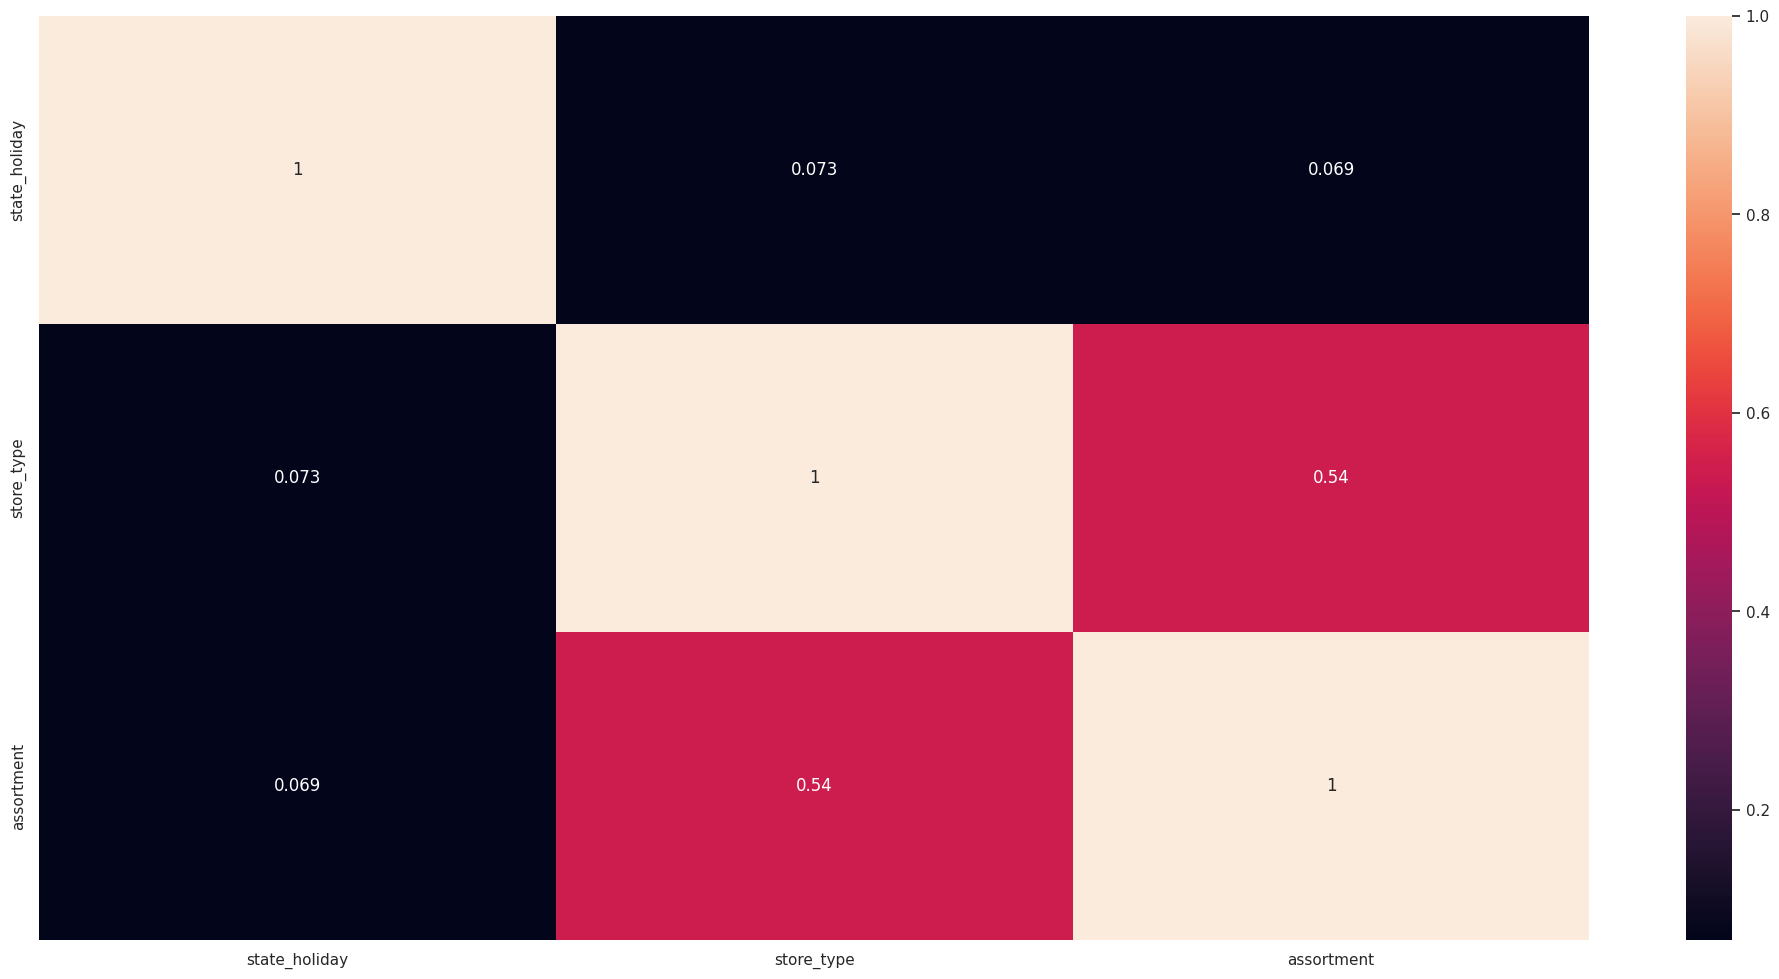

In [45]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cv2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cv3 = cramer_v( cat['state_holiday'], cat['assortment'] )

cv4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cv5 = cramer_v( cat['store_type'], cat['store_type'] )
cv6 = cramer_v( cat['store_type'], cat['assortment'] )

cv7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cv8 = cramer_v( cat['assortment'], cat['store_type'] )
cv9 = cramer_v( cat['assortment'], cat['assortment'] )

# create final dataframe
df = pd.DataFrame( { 'state_holiday' : [cv1, cv2, cv3],
                     'store_type'    : [cv4, cv5, cv6],
                     'assortment'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);

# 4.0 Data Preparation

In [46]:
df4 = df3.copy()

## 4.1 Normalization Method

**COMENTÁRIO:** Ao observar a distribuição das variáveis numéricas (seção 3.1.2), nota-se que NÃO HÁ variáveis com distribuição NORMAL, portanto, não há sentido em executar o método de normalização nesse conjunto de dados

## 4.2 Rescaling Method

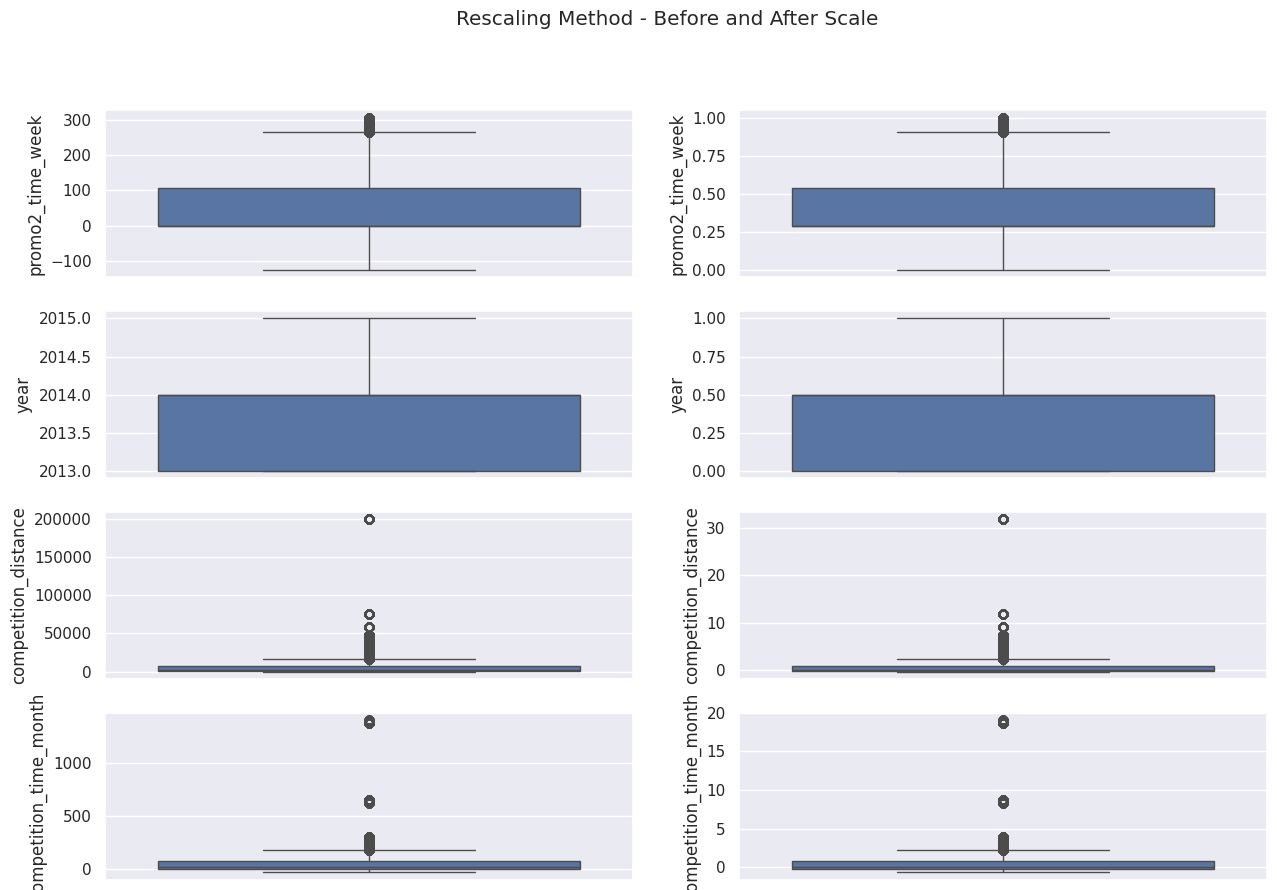

In [47]:
aux = df4[['date', 'sales', 'promo2_time_week', 'year', 'competition_distance', 'competition_time_month']]
df4 = rescaling_features( df4, 'train' )

fig, axes = plt.subplots(4, 2, figsize=(15, 10))
fig.suptitle('Rescaling Method - Before and After Scale')

# promo2_time_wee - Few outliers - MinMax Scaler
sns.boxplot( aux['promo2_time_week'], ax=axes[0,0] );
sns.boxplot( df4['promo2_time_week'], ax=axes[0,1] );

# year - Few outilies - MinMax Scaler
sns.boxplot( aux['year'], ax=axes[1,0] );
sns.boxplot( df4['year'], ax=axes[1,1] );

# competition_distance - Many outliers - Robuster Scaler
sns.boxplot( aux['competition_distance'], ax=axes[2,0] );
sns.boxplot( df4['competition_distance'], ax=axes[2,1] );

# competition_time_month - Many outliers - Robuster Scaler
sns.boxplot( aux['competition_time_month'], ax=axes[3,0] );
sns.boxplot( df4['competition_time_month'], ax=axes[3,1] );


## 4.3 Transformation Method

In [48]:
df4 = encoding_features( df4, 'train' )

### 4.3.1 Encoding Transformation for Categorical Features

In [49]:
# state holiday column - One Hot Encoding
df4[['state_holiday_public holiday', 'state_holiday_regular day', 'state_holiday_easter holiday', 'state_holiday_christmas']].sample(5)


,state_holiday_public holiday,state_holiday_regular day,state_holiday_easter holiday,state_holiday_christmas
929912,False,True,False,False
376028,False,True,False,False
637345,False,True,False,False
210091,False,True,False,False
533771,False,True,False,False


In [50]:
# store type column - Label encoding
df4[['store', 'date', 'store_type']].sample(5)

,store,date,store_type
257198,304,2014-12-09,0
644897,98,2013-11-30,3
724704,740,2013-09-20,3
873075,816,2013-05-10,2
66966,67,2015-06-01,0


In [51]:
# assortment column - Ordinal encoding
df4[['store', 'date', 'assortment']].sample(5)

,store,date,assortment
787737,218,2013-07-25,3
608857,853,2014-01-02,1
174216,277,2015-02-25,3
740668,1094,2013-09-06,1
647272,243,2013-11-28,1


### 4.3.2 Response Variable Magnitude Transformation 

In [52]:
aux = df4[['date', 'sales']]

df4 = magnitude_features( df4 )

aux['new_sales'] = df4['sales']
aux.sample(5)


,date,sales,new_sales
292988,2014-11-01,3839,8.253228
836965,2013-06-11,6224,8.736329
169230,2015-03-02,9852,9.195531
63414,2015-06-05,10776,9.285170
871752,2013-05-11,3817,8.247482


### 4.3.3 Nature Transformation - Variables with cyclical behavior

In [53]:
df4 = ciclyc_features( df4 )

In [54]:
# month
df4[['month', 'month_sin', 'month_cos']].sample(5)

,month,month_sin,month_cos
678739,10,-8.660254e-01,0.500000
446022,5,5.000000e-01,-0.866025
62225,6,1.224647e-16,-1.000000
61996,6,1.224647e-16,-1.000000
225897,1,5.000000e-01,0.866025


In [55]:
# day_of_week
df4[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']].sample(5)

,day_of_week,day_of_week_sin,day_of_week_cos
248947,4,-0.433884,-0.900969
828352,3,0.433884,-0.900969
273221,6,-0.781831,0.623490
533534,1,0.781831,0.623490
481958,6,-0.781831,0.623490


In [56]:
# day
df4[['day', 'day_sin', 'day_cos']].sample(5)

,day,day_sin,day_cos
203804,30,-2.449294e-16,1.000000
899552,16,-2.079117e-01,-0.978148
71424,28,-4.067366e-01,0.913545
680412,30,-2.449294e-16,1.000000
949856,2,4.067366e-01,0.913545


In [57]:
# week_of_year
df4[['week_of_year', 'week_of_year_sin', 'week_of_year_cos']].sample(5)

,week_of_year,week_of_year_sin,week_of_year_cos
577928,5,0.568065,0.822984
597985,2,0.239316,0.970942
351527,35,-0.885456,-0.464723
367141,33,-0.748511,-0.663123
507430,14,0.992709,-0.120537


# 5.0 Feature Selection

In [58]:
df5 = df4.copy()

## 5.1 Create Training Dataset

In [59]:
# remove all features that created new features
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df5 = df5.drop( cols_drop, axis=1 )

# create training dataset 
X_train = df5.copy()
y_train = X_train['sales']

## 5.2 Boruta as Feature Selector

In [60]:
# transform training and test as array values to fit Boruta
# X_train_array = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_array = y_train.values.ravel()

# define Random Forest Regressor
# rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_array, y_train_array )

## 5.3 Selected and NOT Selected Features by Boruta

In [61]:
# get cols selected and not selected by boruta
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

# best features
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [62]:
# features selected by boruta
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo2_time_week', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [63]:
# features NOT selected by boruta
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter holiday',
                            'state_holiday_public holiday', 'state_holiday_regular day', 'week_of_year_sin', 'year']
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter holiday',
 'state_holiday_public holiday',
 'state_holiday_regular day',
 'week_of_year_sin',
 'year']

## 5.4 Final Feature Selection by Me and Boruta

In [64]:
# create a list with all features selected by me and Boruta, add date and sales columns
#final_features = cols_selected_boruta.copy()
#final_features.extend( ['date', 'sales', 'month_sin', 'week_of_year_sin'] )


#final_features = ['store', 'date', 'sales', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
#                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo2_time_week', 
#                  'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos']

final_features = ['store', 'date', 'sales', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo2_time_week', 
                  'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos', 'month_cos']

final_features

['store',
 'date',
 'sales',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'month_cos']

## 5.5 Create Train Dataset with Features to Apply ML Algorithms

In [65]:
# create datasets with final features and csv file
X_train[final_features].to_csv( '../data/train_feat.csv', index=False )

# 6.0 Machine Learning Modelling

In [66]:
X_train = pd.read_csv( '../data/train_feat.csv',  low_memory= False )
X_train['date'] = pd.to_datetime( X_train['date'] )

## 6.1 Split df_feat_train in two datasets: X_train( full ) and X_validation( last 30 weeks )

In [67]:
# calculate period - last 36  weeks
last_date  = X_train[['store', 'date']].groupby( 'store' ).max().reset_index().loc[0, 'date']
first_date = last_date - datetime.timedelta( days=5*6*7 )

last_date_period = last_date

print(f'First date: {first_date}')
print(f'Last date: {last_date}')

# creating full datasets: X_train e X_validation
X_validation = X_train[ X_train['date'] > first_date ]

# create x_train, y_train variables
x_train = X_train[ X_train['date'] <= first_date ]
y_train = x_train['sales']
x_train = x_train.drop( ['date', 'sales'], axis=1 )

# calculate period - first 6 weeks from validation dataset
first_date = X_validation[['store', 'date']].groupby( 'store' ).min().reset_index().loc[0, 'date']
last_date  = first_date + datetime.timedelta( days=6*7 )

print(f'\nFirst date Validation: {first_date}')
print(f'Last date Validation: {last_date}')

# create x_validation, y_validation variables
x_validation = X_validation[ X_validation['date'] < last_date ]
y_validation = x_validation['sales']
x_validation = x_validation.drop( ['date', 'sales'], axis=1 )

print(f'\n { last_date - first_date }' )

First date: 2014-11-21 00:00:00
Last date: 2015-06-19 00:00:00

First date Validation: 2014-11-22 00:00:00
Last date Validation: 2015-01-03 00:00:00

 42 days 00:00:00


## 6.2 Average Model

In [68]:
# create aux_df with database test + response variable (sales)
aux1          = x_validation.copy()
aux1['sales'] = y_validation.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' :  'sales_predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_avg = aux1['sales_predictions']

# calculate performance with response variable "sales" on original scale 
avg_model_result = ml_error( 'Average Model', np.expm1( y_validation ), np.expm1( yhat_avg ) )
avg_model_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1892.237342,0.259841,2476.199792


## 6.3 Linear Regression Model

### 6.3.1 Linear Regression - Single Performance

In [69]:
# define model
lr_model = LinearRegression().fit( x_train, y_train )

# create predictions
yhat_lr = lr_model.predict( x_validation )

# calculate performance
lr_model_result = ml_error( 'Linear Regression Model', np.expm1( y_validation ), np.expm1( yhat_lr) )
lr_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,2689.745568,0.313836,3871.648834


### 6.3.2 Linear Regression - Cross Validation

In [70]:
lr_model_result_cv = cross_validation( X_train, 5, 'Linear Regression', lr_model, verbose=True )
lr_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00



Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2092.39 +/- 315.46,0.3 +/- 0.02,2974.81 +/- 487.73


## 6.4 Liner Regression Regularized (Lasso) - Model

### 6.4.1 Lasso - Single Performance

In [71]:
# define model
lasso_model = Lasso( alpha=0.01 ).fit( x_train, y_train )

# create predictions
yhat_lasso = lasso_model.predict( x_validation )

# calculate performance
lasso_model_result = ml_error( 'Linear Regression Regularized Model - Lasso', np.expm1( y_validation), np.expm1( yhat_lasso) )
lasso_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,2798.044014,0.316678,4026.971993


### 6.4.2 Lasso - Cross Validation

In [72]:
lasso_model_result_cv = cross_validation( X_train, 5, 'Linear Regression Regularized - Lasso', lasso_model, verbose=True )
lasso_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00



Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized - Lasso,2132.06 +/- 359.61,0.29 +/- 0.01,3075.65 +/- 524.31


## 6.5 Random Forest Model

### 6.5.1 Random Forest - Single Performance

In [73]:
# define model
# rf_model = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# create predictions
# yhat_rf = rf_model.predict( x_validation )

# calculate performance
# rf_model_result = ml_error( 'Random Forest Model', np.expm1( y_validation ), np.expm1( yhat_rf) )
# rf_model_result

### 6.5.2 Random Forest - Cross Validation

In [74]:
# rf_result_cv = cross_validation( X_train, 5, 'Random Forest Model', rf_model, verbose=True )
# rf_result_cv

## 6.6 XGBoost Regressor Model

### 6.6.1 XGBoost - Single Performance

In [75]:
# define model with default values of XGBoost's parameter
xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100,
                              eta=0.3, 
                              max_depth=6,  
                              subsample=1,
                              colsample_bytree=1,
                              min_child_weight=1
                            ).fit( x_train, y_train )

# create predictions
yhat_xgb = xgb_model.predict( x_validation )

# calculate performance
xgb_model_result = ml_error( 'XGBoost Regressor', np.expm1( y_validation ), np.expm1( yhat_xgb) )
xgb_model_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1303.187543,0.178397,1829.467719


### 6.6.2 XGBoost - Cross Performance

In [76]:
xgb_model_result_cv = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model, verbose=True )
xgb_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00



Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1056.29 +/- 153.18,0.15 +/- 0.02,1500.18 +/- 216.67


## 6.7 Models Performance

### 6.1.7 Single Performance Table

In [77]:
models_result = pd.concat( [avg_model_result, lr_model_result, lasso_model_result, xgb_model_result] )
models_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1892.237342,0.259841,2476.199792
0,Linear Regression Model,2689.745568,0.313836,3871.648834
0,Linear Regression Regularized Model - Lasso,2798.044014,0.316678,4026.971993
0,XGBoost Regressor,1303.187543,0.178397,1829.467719


### 6.7.2 Cross Validation Performance Table

In [78]:
models_result_cv = pd.concat( [lr_model_result_cv, lasso_model_result_cv, xgb_model_result_cv] )
models_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2092.39 +/- 315.46,0.3 +/- 0.02,2974.81 +/- 487.73
0,Linear Regression Regularized - Lasso,2132.06 +/- 359.61,0.29 +/- 0.01,3075.65 +/- 524.31
0,XGBoost Regressor,1056.29 +/- 153.18,0.15 +/- 0.02,1500.18 +/- 216.67


# 7.0 Hyperparameter Fine Tunning

## 7.1 Random Search

In [79]:
# create dict with names and values parameters
params = { 'n_estimators'     : [150, 170, 250, 300, 350],
           'eta'              : [0.1, 0.3],
           'max_depth'        : [3, 5, 9],
           'subsample'        : [0.1, 0.5, 0.7],
           'colsample_bytree' : [0.3, 0.5, 0.7],
           'min_child_weight' : [3, 8, 15]
          }

NUM_ITERATIONS = 10
xgb_model_result = pd.DataFrame()

for i in range( NUM_ITERATIONS ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in params.items() }
    print(f'Iteration n: { i+1 }. Parameters: { hp } ')

    # define model
    xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'],
                                ).fit( x_train, y_train )

    # create predictions
    yhat_xgb = xgb_model.predict( x_validation )

    # calculate performance
    result = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model, verbose=False )
    xgb_model_result = pd.concat( [xgb_model_result, result] )

xgb_model_result

Iteration n: 1. Parameters: {'n_estimators': 350, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 3} 


Iteration n: 2. Parameters: {'n_estimators': 150, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15} 
Iteration n: 3. Parameters: {'n_estimators': 300, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 15} 
Iteration n: 4. Parameters: {'n_estimators': 250, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8} 
Iteration n: 5. Parameters: {'n_estimators': 300, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15} 
Iteration n: 6. Parameters: {'n_estimators': 170, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8} 
Iteration n: 7. Parameters: {'n_estimators': 300, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8} 
Iteration n: 8. Parameters: {'n_estimators': 300, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_c

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.57 +/- 137.75,0.15 +/- 0.01,1478.1 +/- 191.42
0,XGBoost Regressor,1804.63 +/- 207.29,0.25 +/- 0.01,2593.25 +/- 277.97
0,XGBoost Regressor,1013.79 +/- 151.41,0.14 +/- 0.01,1438.31 +/- 208.88
0,XGBoost Regressor,1222.97 +/- 147.0,0.17 +/- 0.01,1741.5 +/- 223.03
0,XGBoost Regressor,1026.72 +/- 189.94,0.14 +/- 0.02,1456.71 +/- 261.58
0,XGBoost Regressor,1821.4 +/- 215.77,0.25 +/- 0.01,2614.88 +/- 297.97
0,XGBoost Regressor,858.52 +/- 145.59,0.12 +/- 0.01,1239.72 +/- 222.29
0,XGBoost Regressor,1678.68 +/- 182.8,0.23 +/- 0.01,2417.37 +/- 242.96
0,XGBoost Regressor,1264.51 +/- 139.32,0.17 +/- 0.01,1824.12 +/- 195.13
0,XGBoost Regressor,1484.6 +/- 177.93,0.2 +/- 0.01,2133.69 +/- 241.69


# 8.0 Testing Model

## 8.1 Prepare train and test Datasets

In [80]:
# full dataset
X_train         = pd.read_csv( '../data/train_feat.csv',  low_memory= False )
X_train['date'] = pd.to_datetime( X_train['date'] )

x_train = X_train.copy()
x_train = x_train[final_features]
y_train = x_train['sales']
x_train = x_train.drop( columns=['date', 'sales'], axis=1 )

x_train.dtypes

store                             int64
promo                             int64
store_type                        int64
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month          float64
promo2_time_week                float64
day_of_week_sin                 float64
day_of_week_cos                 float64
day_sin                         float64
day_cos                         float64
week_of_year_cos                float64
month_cos                       float64
dtype: object

### 7.2.2 Execute Model with Test DataSet (new data) and Hyperparameters fine tunning

In [81]:
# BEST CROSS VALIDATION RESULT
#	XGBoost Regressor	843.91 +/- 135.2	0.12 +/- 0.01	1210.93 +/- 198.65
# Iteration n: 9. Parameters: {'n_estimators': 350, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 15} 


# define model
xgb_model_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=350,
                                    eta=0.1, 
                                    max_depth=9,  
                                    subsample=0.7,
                                    colsample_bytree=0.5,
                                    min_child_weight=15
                                  ).fit( x_train, y_train )

#xgb_model_tuned_result_cv = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model_tuned, verbose=True )
#xgb_model_tuned_result_cv

# create predictions
#yhat_xgb_tuned = xgb_model_tuned.predict( x_test )

# calculate performance
#xgb_model_tuned_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
#xgb_model_tuned_result


## 7.3 Save Trained Model

In [82]:
# save Trained Model
pickle.dump( xgb_model_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

# 8.0 Call API Model

In [83]:
df_predictions = get_model_prediction( '../data/test.csv', 'local' )
df_predictions.head()

,store,date,sales_predictions,sales,absolute_error
0,1,2015-07-31T00:00:00.000,5068.566895,5263,194.433105
1,2,2015-07-31T00:00:00.000,6562.854980,6064,498.854980
2,3,2015-07-31T00:00:00.000,8829.172852,8314,515.172852
3,4,2015-07-31T00:00:00.000,11710.250000,13995,2284.750000
4,5,2015-07-31T00:00:00.000,5357.667480,4822,535.667480


In [84]:
df_pred= df_predictions[['store', 'sales', 'absolute_error']].groupby('store').mean().reset_index()
df_pred['MAPE'] = round(df_pred['absolute_error'] / df_pred['sales'] * 100, 2)

#df_best =  df_pred[ df_pred['MAPE'] < 25.0]
#df_worst = df_pred[ df_pred['MAPE'] >= 25.0]

#df_store_raw = rename_columns( df_store_raw )

#df_best =  pd.merge( df_best,  df_store_raw, how='inner', on='store' )
#df_worst = pd.merge( df_worst, df_store_raw, how='inner', on='store' )

    

In [85]:
df_predictions['absolute_error'].mean() / df_predictions['sales'] .mean()

0.1607332131524591

In [ ]:
rs1 = RobustScaler()

z = rs.fit_transform